# Motivation

The role of this notebook is to explore the biological significance of the selected tf

In [1]:
%load_ext autoreload
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd
import numpy as np
import os
import sys

import plotly.express as px
import plotly.io as pio
import plotly.graph_objects as go
import matplotlib.pyplot as plt

import multiprocess as mp


# own libraries
SCRIPT_DIR = os.path.dirname(os.path.abspath("pcgna_processing.py"))
sys.path.append(os.path.dirname(SCRIPT_DIR))
sys.path.append('/Users/vlad/Documents/Code/York/iNet_v2/src/')

from NetworkAnalysis.ExperimentSet import ExperimentSet
from NetworkAnalysis import GraphHelper as gh
from NetworkAnalysis.utilities import clustering as cs
from NetworkAnalysis.utilities import sankey_consensus_plot as sky
from NetworkAnalysis.utilities.helpers import save_fig, survival_plot, survival_comp
from NetworkAnalysis.GraphToolExp import GraphToolExperiment as GtExp
from NetworkAnalysis.dea import dea
from NetworkAnalysis.dea import helpers as dea_hp
from NetworkAnalysis.dea import gsea as gsea_hp
from NetworkAnalysis.dea import scatter_plot as sp
sys.path.append(os.path.dirname("../../src"))
# Gsea libraries

pio.templates.default = "ggplot2"

pool = mp.Pool(mp.cpu_count())

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
results_path = "../../results/exp/"
data_base = "../../data/"
base_path = "../../results/"
exp_folder_tumour = "network_I/tum/"  # "/integration_v2.1/ - path from iNET
exp_folder_h42_ctrl = "network_I/healthyControls/"
dea_path = f"{data_base}/non_cancerous/dea/"
dea_path_tum = f"{data_base}/tumour/sel_pruning/dea/"


figures_path = "selective_edge_pruning/sel_tfs/"

vu_output = pd.read_csv(f"{data_base}/metadata/VU_clustering_v3.tsv", sep="\t", index_col="Sample")

tcga_mutations_df = pd.read_csv(f"{data_base}/tumour/mutations_tcga.csv")
tcga_mutations_df = tcga_mutations_df[tcga_mutations_df["count"] != 0].set_index("gene")

tum_tpms = pd.read_csv(f"{data_base}/tumour/TPMs_selected_genes_v3_13k_gc42.tsv", sep="\t", index_col="genes")
tum_tpms_v4 = pd.read_csv(f"{data_base}/tumour/tum_TPMs_selected_genes_gc42_all_v4.tsv", sep="\t", index_col="genes")

# Healthy and metadata
healthy_metadata = pd.read_csv(f"{data_base}/non_cancerous/healthy_bladder_metadata.tsv", sep="\t", index_col="Sample").drop(index=["Y2796_P0"])
healthy_metadata["sample_prcsd"] = healthy_metadata.index.str.replace("-", "_")

healthy_tpm = pd.read_csv(f"{data_base}/non_cancerous/healthy_data_all_gc42_v4.tsv", sep="\t", index_col="gene")
remap_col = {}
for col in healthy_tpm.columns:
    remap_col[col] = col.replace("-", "_")
healthy_tpm = healthy_tpm.rename(columns=remap_col)

# tf list
tf_path = f"{data_base}/metadata/TF_names_v_1.01.txt"
if os.path.exists(tf_path):
    tf_list = np.genfromtxt(fname=tf_path, delimiter="\t", skip_header=1, dtype="str")

# Analysis

In [3]:
def mean_var_bar(df: pd.DataFrame, markers: list):
    df.sort_values(by="tum_mean_expression", ascending=False, inplace=True)
    fig1 = px.bar(df, y="tum_mean_expression", error_y="tum_std_expression", title="Tum expression and variance")
    fig2 = px.bar(df, y="healthy_mean_expression", error_y="healthy_std_expression", title="Healthy expression and variance")

    num_cols = 1
    subplots_config = {
        "num_cols": num_cols,
        "shared_x": False,
        "shared_y": False,
        "h_spacing": 0.25,
        "v_spacing": 0.17,
        "main_title": "Mean expression (log) and variance",
        "height": 700,
        "width": None,
        "y_title": None,
        "x_title": None,
        "specs": None,
    }

    # Color based on high variance
    marker_colors_h = []
    marker_colors_t = []
    for gene, row in df.iterrows():
        if row["varied_label"] == "tum":
            marker_colors_t.append("#F8766D")  # reddish
            marker_colors_h.append("#619CFF")  # bluesh
        elif row["varied_label"] == "h":
            marker_colors_h.append("#F8766D")  # reddish
            marker_colors_t.append("#619CFF")  # bluesh
        elif row["varied_label"] == "both":
            marker_colors_t.append("#D7B740")  # greenish
            marker_colors_h.append("#D7B740")  # greenish
        else:
            marker_colors_t.append("#619CFF")  # bluesh
            marker_colors_h.append("#619CFF")  # bluesh

    fig1.update_traces(marker_color=marker_colors_t)
    fig2.update_traces(marker_color=marker_colors_h)

    figs = [fig1, fig2]
    titles = [None, None]
    fig = gh.helper_multiplots(figs, titles, subplots_config)
    fig.update_yaxes(type="log", title="Tumour", row=1, col=1)
    fig.update_yaxes(type="log", title="Non-cancerous", row=2, col=1)

    for gene in markers:
        data = df.loc[gene]
        if gene in ["KLF4", "ZBTB7C", "GRHL3"]:
            fig.add_annotation(
                text=f"{gene}",
                x=gene,
                y=np.log10(data["tum_mean_expression"]),
                showarrow=True,
                arrowhead=1,
                xref=f"x{1}",
                yref=f"y{1}",
                font=dict(color=px.colors.qualitative.Plotly[0]),
                ax=-30,
                ay=-70,
            )
        else:
            fig.add_annotation(
                text=f"{gene}",
                x=gene,
                y=np.log10(data["tum_mean_expression"]),
                showarrow=True,
                arrowhead=1,
                xref=f"x{1}",
                yref=f"y{1}",
                font=dict(color=px.colors.qualitative.Plotly[0]),
                ax=-60,
                ay=-70,
            )

        fig.add_annotation(
            text=f"{gene}",
            x=gene,
            y=np.log10(data["healthy_mean_expression"]),
            showarrow=True,
            arrowhead=1,
            xref=f"x{2}",
            yref=f"y{2}",
            font=dict(color=px.colors.qualitative.Plotly[0]),
            ax=-20,
            ay=-120,
        )

    return fig

In [4]:
sel_tfs = pd.read_csv(f"{data_base}/tf_ctrl.csv", index_col="gene")
sel_tfs["tum_mean_expression"] = tum_tpms_v4.loc[sel_tfs.index].mean(axis=1)
sel_tfs["tum_median_expression"] = tum_tpms_v4.loc[sel_tfs.index].median(axis=1)
sel_tfs["tum_std_expression"] = tum_tpms_v4.loc[sel_tfs.index].std(axis=1)
sel_tfs["tum_var_expression"] = tum_tpms_v4.loc[sel_tfs.index].var(axis=1)

# sel_tfs.to_csv(f"{figures_path}/selected_tfs.tsv", sep='\t')

In [5]:
# sel_tfs = sel_tfs[~sel_tfs.index.isin(["ELF3", "JUNB"])]
dmy_df = sel_tfs.copy(deep=True)
dmy_df["tum_mean_expression"] = sel_tfs["tum_mean_expression"] + 1
dmy_df["healthy_mean_expression"] = sel_tfs["healthy_mean_expression"] + 1

log = True
fig = px.scatter(
    dmy_df.reset_index(),
    x="tum_mean_expression",
    y="healthy_mean_expression",
    # text="gene",
    color="mut_count",
    size="mut_count",
    hover_data="gene",
    color_continuous_scale=px.colors.sequential.Sunset_r,
    height=700,
    log_x=log,
    log_y=log,
    title=f"Selected TFs ({dmy_df.shape[0]})",
    # trendline='ols',  trendline_options=dict(log_x=True, log_y=True),
)

# Get the top 10 genes with highest healthy median expression
top_genes_h = dmy_df.nlargest(10, "healthy_median_expression").index.tolist()
top_genes_t = dmy_df.nlargest(10, "tum_median_expression").index.tolist()
top_genes_m = dmy_df.nlargest(10, "mut_count").index.tolist()

top_genes = list(set(top_genes_h + top_genes_t + top_genes_m))
top_genes.extend(["FOSL1", "FOXQ1", "MYCL", "STAT2", "IRF7", "MBD6", "ZNF750", "ZNF513", "BNC1", "KLF6", "HOXB6", "ZBTB7C", "KLF4", "ZBTB10", "RUNX1"])
top_genes = list(set(top_genes) - set(["ZNF750", "IRF6", "IRF7", "TGIF1", "DOT1L"]))
inverted = ["SPEN", "ELF3", "ZNF513"]

# Add text annotation for the top 10 genes
for idx, gene in enumerate(top_genes):
    x = dmy_df.loc[dmy_df.index == gene, "tum_mean_expression"].values[0]
    y = dmy_df.loc[dmy_df.index == gene, "healthy_mean_expression"].values[0]
    ay = -30

    xanchor = "right" if idx % 2 == 0 else "left"
    ax = 10 if idx % 2 == 0 else 15

    ay = 30 if gene in inverted else -15

    if log:
        x, y = np.log10(x), np.log10(y)

    fig.add_annotation(x=x, y=y, text=gene, showarrow=True, arrowhead=1, ax=ax, ay=ay, xanchor=xanchor)

fig.update_layout(
    height=900,
    yaxis_title="Non-cancerous TPM",
    xaxis_title="Tum TPM_mean",
    #   paper_bgcolor="rgba(0,0,0,0)",
    xaxis=dict(tickfont=dict(size=16)),
    yaxis=dict(
        tickfont=dict(size=16),
    ),
    font=dict(size=14),
    title="",
)
# fig.add_scatter(x=[0.1, 1500], y=[0.1, 1500], mode='lines+markers', name='')
save_fig(name="sel_tfs_mean_tum_healthy", fig=fig, base_path=figures_path, width=1400, height=700)
# fig.show()

In [6]:
# markers = ['BNC1', "AHR", 'OVOL1', "HES2", ]
high_varied_tum = [
    "EGR1",
    "FOXQ1",
    "ATF3",
    "MYCL",
    "TP63",
    "BHLHE41",
    "FOSL1",
    "OVOL1",
    "MSX2",
    "ZNF750",
    "ZNF552",
    "JRK",
    "HOXB6",
    "HES2",
    "EBF4",
    "REL",
    "BNC1",
    "NR4A2",
    "KLF4",
    "ZBTB7C",
    "GRHL3",
]
high_varied_h = [
    "JUN",
    "ETS2",
    "KLF6",
    "ATF3",
    "FOSL1",
    "EGR1",
    "MAFF",
    "OVOL1",
    "MAFK",
    "ZNF750",
    "HES2",
    "EBF4",
    "ARID5B",
    "NR4A2",
    "KLF4",
    "BNC1",
    "FOXQ1",
    "ZBTB7C",
    "ZBTB10",
    "MYCL",
]
cmn_varied = ["OVOL1", "FOSL1", "KLF4", "BNC1", "MYCL", "NR4A2", "ZBTB7C", "FOXQ1", "ZNF750", "EGR1", "HES2", "ATF3", "EBF4"]
cmn_varied = list(set(high_varied_h) & set(high_varied_tum))
only_tum = list(set(high_varied_tum) - set(cmn_varied))
only_h = list(set(high_varied_h) - set(cmn_varied))

sel_tfs["varied_label"] = ""
sel_tfs.loc[high_varied_tum, "varied_label"] = "tum"
sel_tfs.loc[high_varied_h, "varied_label"] = "h"
sel_tfs.loc[cmn_varied, "varied_label"] = "both"

markers = ["GRHL3", "OVOL1", "JRK", "HES2", "EBF4", "NR4A2", "KLF4", "ZBTB7C", "KLF6", "ETS2"]
fig = mean_var_bar(sel_tfs, markers=markers)
fig.update_layout(
    height=900,
    #   paper_bgcolor="rgba(0,0,0,0)",
    xaxis=dict(tickfont=dict(size=16)),
    yaxis=dict(tickfont=dict(size=16)),
    font=dict(size=14),
    title="",
)
save_fig(name="sel_tfs_var_tum_healthy", fig=fig, base_path=figures_path, width=1600, height=900)
# fig.show()
del fig

## Comparing with known markers

In [7]:
luminal_markers = ["KRT20", "PPARG", "FOXA1", "GATA3", "SNX31", "UPK1A", "UPK2", "FGFR3"]
basal_markers = ["CD44", "KRT6A", "KRT5", "KRT14", "COL17A1"]
squamos_markers = ["DSC3", "GSDMC", "TCGM1", "PI3", "TP63"]
immune_markers = ["CD274", "PDCD1LG2", "IDO1", "CXCL11", "L1CAM", "SAA1"]
neural_diff = ["MSI1", "PLEKHG4B", "GNG4", "PEG10", "RND2", "APLP1", "SOX2", "TUBB2B"]

# TCGA markers - main paper
emt_claudin = ["ZEB1", "ZEB2", "SNAI1", "TWIST1", "CDH2", "CLDN3", "CLDN4", "CLDN7"]
ecm_muscle = ["PGM5", "DES", "C7", "SFRP4", "COMP", "SGCD"]

tcga_markers = luminal_markers + basal_markers + squamos_markers + immune_markers + neural_diff + emt_claudin + ecm_muscle

In [8]:
set(sel_tfs.index) & set(tcga_markers)

{'TP63'}

### Urothelium type markers

In [9]:
tf_diff = ["P63", "FOXA1", "PPARG", "RARG", "IRF1", "ELF3", "GRHL3", "KLF5", "GATA4", "GATA6", "GATA3"]
krt = ["KRT13", "KRT14", "KRT15", "KRT20"]
upk = ["UPK1B", "UPK1A", "UPK3A", "UPK2"]
cld = ["CLDN3", "CLDN4", "CLDN5"]

egfr_fam = ["EGFR", "ERBB2", "ERBB3", "ERBB4", "EGF", "AREG", "HBEGF", "TGFA", "BTC", "EREG"]
fgfr_fam = ["FGFR1", "FGFR2", "FGFR3", "FGF1", "FGF2"]
map_kpathway = ["RAS", "RAF", "MEK1", "MEK2", "MEK3", "MEK4", "ERK"]
pi3_kpathway = ["PIK3C3", "PIK3R2", "PIK3C2B", "AKT1", "AKT2"]
others = ["MKI67", "MCM2", "UPK3A", "ZO1", "TJP1", "ZO2", "TJP2", "ZO3", "TJP3"]
hox_ur = ["HOXB2", "HOXB3", "HOXB5", "HOXB6", "HOXB8"]
hox_bla = ["HOXA9", "HOXA10", "HOXA11", "HOXA13"]

diff_markers = tf_diff + cld + krt + upk

uro_markers = diff_markers + egfr_fam + fgfr_fam + map_kpathway + pi3_kpathway + others + hox_ur + hox_bla

In [10]:
set(sel_tfs.index) & set(uro_markers)

{'ELF3', 'GRHL3', 'HOXB6', 'KLF5'}

### Lund type markers

In [11]:
lund_qtc1 = ["FLI1", "FOXP3", "ILKZF1", "IRF4", "IRF8", "RUNX3", "SCML4", "SPI1", "STAT4", "TBX21", "TFEC"]
lund_qtc2 = ["AEBP1", "BNC2", "GLI2", "GLIS1", "HIC1", "MSC", "PPRX1", "PPRX2", "TGFB1I1", "TWIST1"]
lund_qtc3 = ["EBF1", "HEYL", "LEF1", "MEF2C", "TCF4", "ZEB1", "ZEB2"]
lund_qtc8 = ["GATA5", "HAND1", "HAND2", "KLF16"]
lund_qtc17 = ["ARID5A", "BATF3", "VENTX"]
lund_ba_mes = lund_qtc1 + lund_qtc2 + lund_qtc3 + lund_qtc8 + lund_qtc17

lund_ba_sq = ["BRIP1", "E2F7", "FOXM1", "ZNF367", "IRF1", "SP110", "STAT1"]
lund_mes = ["TP53", "RB1", "FGFR3", "ANKHD1", "VIM", "ZEB2"]
ba_sq_inf = ["CDH3", "EGFR"]

lund_sc_ne = ["CHGA", "SYP", "ENO2", "EPCAM"]  # Highly expressed

lund_markers = lund_ba_mes + lund_ba_sq + lund_mes + ba_sq_inf + lund_sc_ne

In [12]:
set(sel_tfs.index) & set(lund_markers)

{'KLF16', 'SP110', 'STAT1'}

### Immune markers

In [13]:
b_cells = [
    "BCL2",
    "BCL6",
    "CD19",
    "CD1D",
    "CD22",
    "CD24",
    "CD27",
    "CD274",
    "CD34",
    "CD38",
    "CD40",
    "CD44",
    "CD5",
    "CD53",
    "CD69",
    "CD72",
    "CD79A",
    "CD79B",
    "CD80",
    "CD86",
    "CD93",
    "CR2",
    "CXCR4",
    "CXCR5",
    "FAS",
    "FCER2",
    "FCRL4" "HAVCR1",
    "IL10",
    "IL2RA",
    "IL7R",
    "IRF4",
    "ITGAX",
    "LILRB1",
    "MME",
    "MS4A1",
    "NT5E",
    "PDCD1LG2",
    "PRDM1",
    "PTPRC",
    "SDC1",
    "SPN",
    "TFRC",
    "TLR9",
    "TNFRSF13B",
    "TNFRSF13C",
    "TNFRSF17",
    "XBP1",
]
t_cells = [
    "CD4",
    "CD8",
    "CCR4",
    "CCR5",
    "CCR6",
    "CCR7",
    "CCR10",
    "CD127",
    "CD27",
    "CD28",
    "CD38",
    "CD58",
    "CD69",
    "CTLA4",
    "CXCR3",
    "FAS",
    "IL2RA",
    "IL2RB",
    "ITGAE",
    "ITGAL",
    "KLRB1",
    "NCAM1",
    "PECAM1",
    "PTGDR2",
    "SELL",
    "IFNG",
    "IL10",
    "IL13",
    "IL17A",
    "IL2",
    "IL21",
    "IL22",
    "IL25",
    "IL26",
    "IL4",
    "IL5",
    "IL9",
    "TGFB1",
    "TNF",
    "AHR",
    "EOMES",
    "FOXO4",
    "FOXP1",
    "FOXP3",
    "GATA3",
    "IRF4",
    "LEF1",
    "PRDM1",
    "RORC",
    "STAT4",
    "TBX21",
    "TCF7",
    "GZMA",
]

nk_cells = [
    "B3GAT1",
    "CCR7",
    "CD16",
    "CD2",
    "CD226",
    "CD244",
    "CD27",
    "CD300A",
    "CD34",
    "CD58",
    "CD59",
    "CD69",
    "CSF2",
    "CX3CR1",
    "CXCR1",
    "CXCR3",
    "CXCR4",
    "EOMES",
    "GZMB",
    "ICAM1",
    "IFNG",
    "IL1R1",
    "IL22",
    "IL2RB",
    "IL7R",
    "ITGA1",
    "Itga2",
    "ITGAL",
    "ITGAM",
    "ITGB2",
    "KIR2DL1",
    "KIR2DL2",
    "KIT",
    "Klrb1c",
    "KLRC1",
    "KLRC2",
    "KLRD1",
    "KLRF1",
    "KLRG1",
    "KLRK1",
    "LILRB1",
    "Klra4",
    "Klra8",
    "NCAM1",
    "NCR1",
    "NCR2",
    "NCR3",
    "PRF1",
    "SELL",
    "SIGLEC7",
    "SLAMF6",
    "SPN",
    "TBX21",
    "TNF",
]

macrophages_cells = [
    "ADGRE1",
    "CCR2",
    "CD14",
    "CD68",
    "CSF1R",
    "Ly6c1",
    "MARCO",
    "MRC1",
    "NOS2",
    "PPARG",
    "SIGLEC1",
    "TLR2",
    "ARG1",
    "CD163",
    "CD200R1",
    "CD80",
    "CD86",
    "CLEC10A",
    "CLEC7A",
    "CSF2",
    "CX3CR1",
    "FCGR1A",
    "ITGAM",
    "MERTK",
    "PDCD1LG2",
    "Retnla",
    "TNF",
    "CCL22",
    "CD36",
    "CD40",
    "IL10",
    "IL1B",
    "IL6",
    "LGALS3",
    "TLR4",
    "CCL2",
    "CCR5",
    "CD209",
    "CD63",
    "CD86",
    "CSF1",
    "CXCL2",
    "FCGR3A",
    "IFNG",
    "IL4",
    "IRF4",
    "ITGAX",
    "MSR1",
    "PDGFB",
    "PTPRC",
    "STAT6",
    "TIMD4",
    "Chil3",
    "CLEC6A",
    "IL1R1",
    "ITGB2",
    "PDCD1LG2",
    "TLR7",
]

monocyte_cells = [
    "CD14",
    "CD16",
    "CSF1R",
    "CX3CR1",
    "ITGAM",
    "ITGAX",
    "LY6C1",
    "CCR2",
    "CXCR4",
    "FCGR1A",
    "SELL",
    "SPN",
    "ADGRE1",
    "CCR7",
    "TNF",
    "CD86",
    "IL10",
    "IL1B",
    "MERTK",
    "TREML4",
    "CD209",
    "NR4A1",
    "Ly6a",
    "PTPRC",
    "IL3RA",
    "CD27",
    "CCR5",
    "CD32",
    "CD1A",
    "MRC1",
    "ITGB3",
    "CD9",
    "CXCR6",
    "CCR1",
    "FLT3",
    "KLF2",
    "CLEC12A",
    "CCR6",
    "CCR8",
    "CD68",
    "CLEC7A",
    "KIT",
    "MAF",
    "MAFB",
    "SPI1",
    "CD1C",
    "PPARG",
    "CEBPB",
    "ITGAE",
    "TEK",
]


immune_markers = b_cells + t_cells + nk_cells + macrophages_cells + monocyte_cells

In [14]:
set(sel_tfs.index) & set(immune_markers)

{'AHR', 'BCL6'}

## Knowles group

Datasets taken from: [Knowles group](https://pathsocjournals.onlinelibrary.wiley.com/doi/full/10.1002/cjp2.261)

In [15]:
up_reg_scc = pd.read_csv(f"{data_base}/metadata/scc_up_regulated.csv", index_col="gene")
down_reg_scc = pd.read_csv(f"{data_base}/metadata/scc_down_regulated.csv", index_col="gene")

found_upReg_scc = list(set(sel_tfs.index) & set(up_reg_scc.index))
found_downReg_scc = list(set(sel_tfs.index) & set(down_reg_scc.index))

In [16]:
print(f"Up-reg in scc {found_upReg_scc}")
print(f"Up-reg in scc {set(sel_tfs.index) & set(up_reg_scc[up_reg_scc['sig_reg_tcga_sq']=='yes'].index)}")

Up-reg in scc ['HES2', 'JUN', 'EGR1', 'FOSL1', 'NFIL3', 'KLF16', 'KLF4', 'BNC1']
Up-reg in scc {'HES2', 'JUN', 'FOSL1', 'NFIL3', 'KLF4', 'BNC1'}


In [17]:
print(f"Up-reg in scc {set(sel_tfs.index) & set(found_downReg_scc)}")
print(f"Up-reg in scc {set(sel_tfs.index) & set(down_reg_scc[down_reg_scc['sig_reg_tcga_sq']=='yes'].index)}")

Up-reg in scc {'ZSCAN16', 'ELF3', 'FOXQ1', 'BHLHE41', 'REPIN1', 'POGK', 'MECOM'}
Up-reg in scc {'POGK', 'ZSCAN16', 'BHLHE41', 'REPIN1'}


# Morpheus

## Prepare for Morpheus
Outliers for standard log2 TPMS and norm of log, after applying agglomerative clustering with 1-pearson correlation.

```Python
outliers_log2 = ['TCGA-C4-A0EZ', 'TCGA-DK-AA6W', 'TCGA-G2-A2EL', 'TCGA-BL-A3JM', 'TCGA-XF-A9T2', 'TCGA-XF-AAMH', 'TCGA-XF-A9ST', 'TCGA-GC-A4ZW', 'TCGA-HQ-A2OF', 'TCGA-DK-AA6T', 'TCGA-BT-A2LA', 'TCGA-XF-AAN7', 'TCGA-FJ-A871', 'TCGA-CF-A3MF']
```

```Python
norm_outliers = ['TCGA-2F-A9KW', 'TCGA-XF-A9ST', 'TCGA-BL-A3JM', 'TCGA-XF-A9T2', 'TCGA-XF-AAMH', 'TCGA-DK-AA6T', 'TCGA-BT-A2LA', 'TCGA-XF-AAN7', 'TCGA-FJ-A871', 'TCGA-C4-A0EZ', 'TCGA-DK-AA6W', 'TCGA-G2-A2EL']
```

<!-- ![alt text](selective_edge_pruning/sel_tf_log2.png)
![alt text](selective_edge_pruning/sel_tf_norm_log2.png) -->



In [18]:
outliers_log2 = [
    "TCGA-C4-A0EZ",
    "TCGA-DK-AA6W",
    "TCGA-G2-A2EL",
    "TCGA-BL-A3JM",
    "TCGA-XF-A9T2",
    "TCGA-XF-AAMH",
    "TCGA-XF-A9ST",
    "TCGA-GC-A4ZW",
    "TCGA-HQ-A2OF",
    "TCGA-DK-AA6T",
    "TCGA-BT-A2LA",
    "TCGA-XF-AAN7",
    "TCGA-FJ-A871",
    "TCGA-CF-A3MF",
]

norm_outliers = [
    "TCGA-2F-A9KW",
    "TCGA-XF-A9ST",
    "TCGA-BL-A3JM",
    "TCGA-XF-A9T2",
    "TCGA-XF-AAMH",
    "TCGA-DK-AA6T",
    "TCGA-BT-A2LA",
    "TCGA-XF-AAN7",
    "TCGA-FJ-A871",
    "TCGA-C4-A0EZ",
    "TCGA-DK-AA6W",
    "TCGA-G2-A2EL",
]

cmn_outliars = set(outliers_log2) & set(norm_outliers)

print(f"### Num outliers for standard log2 {len(outliers_log2)}.\n --> {outliers_log2}")
print(f"### Num outliers for norm log2 {len(norm_outliers)}.\n --> {norm_outliers}")
print(f"### Common outliers *{len(cmn_outliars)}*.\n --> {cmn_outliars}")

### Num outliers for standard log2 14.
 --> ['TCGA-C4-A0EZ', 'TCGA-DK-AA6W', 'TCGA-G2-A2EL', 'TCGA-BL-A3JM', 'TCGA-XF-A9T2', 'TCGA-XF-AAMH', 'TCGA-XF-A9ST', 'TCGA-GC-A4ZW', 'TCGA-HQ-A2OF', 'TCGA-DK-AA6T', 'TCGA-BT-A2LA', 'TCGA-XF-AAN7', 'TCGA-FJ-A871', 'TCGA-CF-A3MF']
### Num outliers for norm log2 12.
 --> ['TCGA-2F-A9KW', 'TCGA-XF-A9ST', 'TCGA-BL-A3JM', 'TCGA-XF-A9T2', 'TCGA-XF-AAMH', 'TCGA-DK-AA6T', 'TCGA-BT-A2LA', 'TCGA-XF-AAN7', 'TCGA-FJ-A871', 'TCGA-C4-A0EZ', 'TCGA-DK-AA6W', 'TCGA-G2-A2EL']
### Common outliers *11*.
 --> {'TCGA-DK-AA6T', 'TCGA-C4-A0EZ', 'TCGA-XF-A9T2', 'TCGA-XF-AAN7', 'TCGA-XF-A9ST', 'TCGA-BT-A2LA', 'TCGA-DK-AA6W', 'TCGA-BL-A3JM', 'TCGA-FJ-A871', 'TCGA-XF-AAMH', 'TCGA-G2-A2EL'}


In [19]:
dmy_df = tum_tpms_v4.loc[sel_tfs.index]
dmy_df = np.log2(dmy_df + 1)

sel_metadata = ["KMeans_labels_6", "consensus", "TCGA408_classifier", "Lund2017.subtype", "ESTIMATE_score", "Immune_score", "Stromal_score", "tumor_stage"]
dmy_df = pd.concat([vu_output[sel_metadata].T, dmy_df], axis=0).dropna(axis=1)

# Remove outliers
dmy_df = dmy_df[list(set(dmy_df.columns) - set(cmn_outliars))]

# Adding notes on the genes
dmy_df["Notes"] = ""
dmy_df.loc[dmy_df.index.isin(lund_markers), "Notes"] = "Lund marker"
dmy_df.loc[dmy_df.index.isin(immune_markers), "Notes"] = "Immune marker"
dmy_df.loc[dmy_df.index.isin(uro_markers), "Notes"] = "Uro markers"
dmy_df.loc[dmy_df.index.isin(tcga_markers), "Notes"] = "TCGA markers"

dmy_df = dmy_df[["Notes"] + list(dmy_df.columns[:-1])]
dmy_df.to_csv(f"{figures_path}/log2_sel_tfs_no_outliers.tsv", sep="\t")

/var/folders/wd/10ylrkx55m78njljcl21yt2c0000gn/T/ipykernel_67045/1748207700.py:11: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



## Importing Morpheus

In [20]:
morpheus_path = "selective_edge_pruning/morpheus/"

morp_df = pd.read_csv(f"{morpheus_path}/15_CS_norm_log2_sel_tfs_no_outliers.gct", sep="\t", skiprows=2)
columns = morp_df["id"]
morp_df = morp_df.drop(columns=["Notes"]).transpose()
morp_df.columns = columns
morp_df = morp_df.iloc[2:, :]

morp_df["dendrogram_cut"] = morp_df["dendrogram_cut"].astype(float).astype(int)


morp_df["dendrogram_cut"] = morp_df["dendrogram_cut"].astype(int)
morp_df["dendrogram_label"] = morp_df["dendrogram_cut"].replace({3: "mes-like", 4: "large-basal", 5: "small-basal", 13: "large-luminal", 12: "lum-inf"})

keep_clusters = []
# Size of 1%
size_th = round(morp_df.shape[0] * 0.01)
for cluster, size in morp_df["dendrogram_cut"].value_counts().items():
    if size > 5:
        keep_clusters.append(cluster)

# Drop clusters that are smaller than 1% of the cohort size
morp_df = morp_df.loc[morp_df["dendrogram_cut"].isin(keep_clusters)]
morp_df.shape

# morp_df.reset_index(names='Sample').to_csv(f"{figures_path}/morph_cs_v1.tsv", index=False, sep="\t")

(378, 108)

In [66]:
# Sankey
morp_df.rename_axis("sample", axis="columns", inplace=True)
reorder_cols = [
    # "TCGA408_classifier",
    # "consensus",
    "Lund2017.subtype",
    "dendrogram_cut",
    "KMeans_labels_6",
    # "Lund2017.subtype",
]
morp_df["dendrogram_cut"] = morp_df["dendrogram_cut"].astype(str)
meta, sky_fig = sky.main(df=morp_df, reorder_cols=reorder_cols, title="MIBC stratification based on the TF from selective edge pruning", retMeta=True)
sky_fig.update_layout(
    title="",
    template="ggplot2",  # "ggplot2", "plotly_white"
    font=dict(size=16),
    paper_bgcolor="rgba(0,0,0,0)",
)
sky_fig.show()
save_fig(name="sky_sel_tfs", fig=sky_fig, base_path=figures_path, width=1200, height=600)
del sky_fig

## Dumbell plots

In [22]:
# Main function to see the differences
def dumbell_plots(morp_df: pd.DataFrame, tum_df: pd.DataFrame, sel_tfs: pd.DataFrame, cls_1="", cls_2="", markers=[], log=False):

    cluster_1, cluster_2 = int(cls_1.split("_")[-1]), int(cls_2.split("_")[-1])

    samples_1 = morp_df[morp_df["dendrogram_cut"] == cluster_1].index
    samples_2 = morp_df[morp_df["dendrogram_cut"] == cluster_2].index

    # Reconstruct the TPM
    dmy_df = tum_df.loc[tum_df.index.isin(sel_tfs.index)]
    df_1 = dmy_df[samples_1]
    df_1[cls_1] = df_1.mean(axis=1)

    dmy_df = tum_df.loc[tum_df.index.isin(sel_tfs.index)]
    df_2 = dmy_df[samples_2]
    df_2[cls_2] = df_2.mean(axis=1)

    comb_df = pd.concat([df_1[cls_1], df_2[cls_2]], axis=1)

    # Prepare for plotting
    plot_data = {"line_x": [], "line_y": [], cls_1: [], cls_2: []}

    y_axis_title = "TPM mean"
    if log:
        comb_df[cls_1] = np.log2(comb_df[cls_1] + 1)
        comb_df[cls_2] = np.log2(comb_df[cls_2] + 1)
        y_axis_title = "Log2(TPM + 1) mean "

    comb_df["diff"] = np.abs(comb_df[cls_1] - comb_df[cls_2])
    comb_df.sort_values(by="diff", ascending=False, inplace=True)

    genes = list(comb_df.index)

    # generate the data for plots
    for gene, row in comb_df.iterrows():
        # print(gene)

        val_1, val_2 = row[cls_1], row[cls_2]
        # The data for two scatter points cls_1 and cls_2
        plot_data[cls_1].extend([val_1])
        plot_data[cls_2].extend([val_2])
        # The line between the two clases
        plot_data["line_y"].extend(
            [
                val_1,
                val_2,
                None,
            ]
        )
        plot_data["line_x"].extend([gene, gene, None])

    # plotting
    fig = go.Figure(
        data=[
            go.Scatter(x=plot_data["line_x"], y=plot_data["line_y"], mode="lines", showlegend=False, marker=dict(color="grey")),
            go.Scatter(
                y=plot_data[cls_1],
                x=genes,
                mode="markers",
                name=cls_1,
                marker=dict(
                    # color="green",
                    size=10
                ),
            ),
            go.Scatter(
                y=plot_data[cls_2],
                x=genes,
                mode="markers",
                name=cls_2,
                marker=dict(
                    # color="blue",
                    size=10
                ),
            ),
        ]
    )

    # Add title and change the figure size
    fig.update_layout(title=f"Changes between {cls_1} and {cls_2}", yaxis_title=y_axis_title, xaxis_title="Gene", legend_itemclick=False)

    fig.update_xaxes()
    # Add markers

    annotations = []
    for i, marker in enumerate(markers):
        sel_df = comb_df.loc[marker][[cls_1, cls_2]]
        x = marker
        # avoid overlapping
        xanchor = "right" if i % 2 == 0 else "left"
        ax = -10 if i % 2 == 0 else 10
        y = sel_df.max() if i % 2 == 0 else sel_df.min()
        ay = -10 if i % 2 == 0 else 50

        fig.add_annotation(x=x, y=y, text=marker, showarrow=True, ax=ax, ay=ay, xanchor=xanchor)  # No horizontal offset
        annotations.append(
            {
                "x": x,
                "y": y,
                "text": marker,
                "showarrow": True,
                "ax": ax,
                "ay": ay,
                "xanchor": xanchor,
            }
        )

    return fig, comb_df, annotations

In [23]:
cluster_1, label_1 = 3, "mesLike"
cluster_2, label_2 = 5, "smallBasal"
cls_1, cls_2 = f"{label_1}_{cluster_1}", f"{label_2}_{cluster_2}"
markers = ["TP63", "HES2", "GRHL3", "BNC1", "IRF6", "ZNF750", "OVOL1", "KLF5", "ETS2", "AHR", "STAT1", "ZBTB7C"]

morp_df["dendrogram_cut"] = morp_df["dendrogram_cut"].astype(float).astype(int)
fig5, df, ann5 = dumbell_plots(morp_df=morp_df, tum_df=tum_tpms_v4, sel_tfs=sel_tfs, cls_1=cls_1, cls_2=cls_2, markers=markers, log=True)
title5 = f"{cls_1} vs {cls_2}"
# fig5

In [24]:
# Basal large vs Luminal
log = True
cluster_1, label_1 = 13, "luminal"
cluster_2, label_2 = 4, "basal"
cls_1, cls_2 = f"{label_1}_{cluster_1}", f"{label_2}_{cluster_2}"
markers = ["JRK", "HES2", "BNC1", "ELF3", "FOSL1", "MYCL", "FOXQ1", "GRHL3", "STAT1", "HOXB6", "TP63"]

fig1, df, ann1 = dumbell_plots(morp_df=morp_df, tum_df=tum_tpms_v4, sel_tfs=sel_tfs, cls_1=cls_1, cls_2=cls_2, markers=markers, log=True)
title1 = f"A) {cls_1} vs {cls_2}"

# Lum vs LumInf
cluster_1, label_1 = 13, "luminal"
cluster_2, label_2 = 12, "lumInf"
cls_1, cls_2 = f"{label_1}_{cluster_1}", f"{label_2}_{cluster_2}"
markers = ["TP63", "MECOM", "IRF6", "KLF6", "IRF7", "ELF3", "BNC1"]

fig2, df, ann2 = dumbell_plots(morp_df=morp_df, tum_df=tum_tpms_v4, sel_tfs=sel_tfs, cls_1=cls_1, cls_2=cls_2, markers=markers, log=True)
title2 = f"B) {cls_1} vs {cls_2}"

# Small vs LumInf
cluster_1, label_1 = 5, "smallBasal"
cluster_2, label_2 = 12, "lumInf"
cls_1, cls_2 = f"{label_1}_{cluster_1}", f"{label_2}_{cluster_2}"
markers = ["TP63", "MYCL", "BNC1", "GRHL3", "HES2", "MSX2", "IRF6", "HOXB6"]

fig3, df, ann3 = dumbell_plots(morp_df=morp_df, tum_df=tum_tpms_v4, sel_tfs=sel_tfs, cls_1=cls_1, cls_2=cls_2, markers=markers, log=True)
title3 = f"C) {cls_1} vs {cls_2}"

# Mes-like vs Basal
cluster_1, label_1 = 3, "mesLike"
cluster_2, label_2 = 4, "basal"
cls_1, cls_2 = f"{label_1}_{cluster_1}", f"{label_2}_{cluster_2}"
markers = ["GRHL3", "BNC1", "ELF3", "MYCL", "HES2", "TP63", "IRF6", "STAT1", "ZBTB7C", "ZNF750", "JUNB"]

fig4, df, ann4 = dumbell_plots(morp_df=morp_df, tum_df=tum_tpms_v4, sel_tfs=sel_tfs, cls_1=cls_1, cls_2=cls_2, markers=markers, log=True)
title4 = f"D) {cls_1} vs {cls_2}"

# Mes-like vs small basal
cluster_1, label_1 = 3, "mesLike"
cluster_2, label_2 = 5, "smallBasal"
cls_1, cls_2 = f"{label_1}_{cluster_1}", f"{label_2}_{cluster_2}"
markers = ["TP63", "HES2", "GRHL3", "BNC1", "IRF6", "ZNF750", "OVOL1", "KLF5", "ETS2", "AHR", "STAT1", "ZBTB7C", "ELF3", "REL", "IRF7"]

fig5, df, ann5 = dumbell_plots(morp_df=morp_df, tum_df=tum_tpms_v4, sel_tfs=sel_tfs, cls_1=cls_1, cls_2=cls_2, markers=markers, log=True)
title5 = f"E) {cls_1} vs {cls_2}"


# Small basal vs Basla
cluster_1, label_1 = 4, "basal"
cluster_2, label_2 = 5, "smallBasal"
cls_1, cls_2 = f"{label_1}_{cluster_1}", f"{label_2}_{cluster_2}"
markers = ["ZBTB7C", "MECOM", "TP63", "ELF3", "KLF5", "MSX2"]

fig6, df, ann6 = dumbell_plots(morp_df=morp_df, tum_df=tum_tpms_v4, sel_tfs=sel_tfs, cls_1=cls_1, cls_2=cls_2, markers=markers, log=True)
title6 = f"F) {cls_1} vs {cls_2}"

In [25]:
num_cols = 2
subplots_config = {
    "num_cols": num_cols,
    "shared_x": False,
    "shared_y": False,
    "h_spacing": 0.04,
    "v_spacing": 0.1,
    "main_title": "Gene differences",
    "height": 1800,
    "width": None,
    "y_title": None,
    "x_title": None,
    "specs": None,
}

figs, titles = [fig1, fig2, fig3, fig4, fig5, fig6], [title1, title2, title3, title4, title5, title6]
annotations = [ann1, ann2, ann3, ann4, ann5, ann6]
# annotations = []

# Defining the trace colors
traces_names = ["mesLike_3", "basal_4", "luminal_13", "lumInf_12", "smallBasal_5"]
trace_colors = {}
for idx, name in enumerate(traces_names):
    trace_colors[name] = px.colors.qualitative.Plotly[idx]

# Making sure that we only display the traces once
displayed_legends = set()
for fig in figs:
    for trace in fig.data:
        if trace.name:
            trace.update(marker=dict(color=trace_colors[trace.name]))

            # Manage legend entries
            if trace.name not in displayed_legends:
                displayed_legends.add(trace.name)
                trace.showlegend = True  # Show legend for this trace
            else:
                trace.showlegend = False  # Hide legend for this trace

fig = gh.helper_multiplots(figs, titles, subplots_config)

# Adding the annotations to the subtplots
idx_row, idx_col = 1, 1

for i, ann in enumerate(annotations):
    for idx, elem in enumerate(ann):
        fig.add_annotation(elem, row=idx_row, col=idx_col)
    if idx_col % num_cols == 0:
        idx_col = 0
        idx_row += 1
    idx_col += 1

fig.update_layout(
    height=2100,
    yaxis_title="log2(TPM+1)",
    showlegend=True,
    legend=dict(
        orientation="h",
        title="Subtypes",
        yanchor="bottom",
        y=1.0,
        xanchor="center",
        x=0.5,
        bgcolor="rgba(0,0,0,0)",
        font=dict(size=16, color="#003366"),
    ),
    #   paper_bgcolor="rgba(0,0,0,0)",
    xaxis=dict(tickfont=dict(size=16)),
    yaxis=dict(tickfont=dict(size=16),),
    font=dict(size=14),
    title="",
)
fig.show()
del fig
# save_fig(name="dumbell_sel_tfs", fig=fig, base_path=figures_path, height=1700, width=2700)

### Single plot version

In [26]:
# Single scatter plot in plotly
def plot_cluster_means(morp_df: pd.DataFrame, tum_df: pd.DataFrame, sel_tfs: pd.DataFrame, cls_1="", cls_2="", markers=[], log=False):

    cluster_1, cluster_2 = int(cls_1.split("_")[-1]), int(cls_2.split("_")[-1])

    samples_1 = morp_df[morp_df["dendrogram_cut"] == cluster_1].index
    samples_2 = morp_df[morp_df["dendrogram_cut"] == cluster_2].index

    # Reconstruct the TPM
    dmy_df = tum_df.loc[tum_df.index.isin(sel_tfs.index)]
    df_1 = dmy_df[samples_1]
    df_1[cls_1] = df_1.mean(axis=1)

    dmy_df = tum_df.loc[tum_df.index.isin(sel_tfs.index)]
    df_2 = dmy_df[samples_2]
    df_2[cls_2] = df_2.mean(axis=1)

    comb_df = pd.concat([df_1[cls_1], df_2[cls_2]], axis=1)
    fig = px.scatter(
        comb_df.reset_index(),
        x=cls_1,
        y=cls_2,
        hover_data="genes",
        title=f"{cls_1} vs {cls_2}",
        log_x=log,
        log_y=log,
        trendline="ols",
        trendline_color_override="red",
        trendline_options=dict(log_x=log, log_y=log),
    )

    for marker in markers:
        dmy = comb_df.loc[marker]
        x, y = dmy.values[0], dmy.values[1]
        if log:
            x, y = np.log10(x), np.log10(y)

        fig.add_annotation(
            x=x,
            y=y,
            text=dmy.name,
            showarrow=False,
            xanchor="right",
        )
    return fig, comb_df

In [27]:
if 0:
    cluster_1, label_1 = 9, "basal"
    cluster_2, label_2 = 7, "luminf"
    cls_1, cls_2 = f"{label_1}_{cluster_1}", f"{label_2}_{cluster_2}"

    markers = ["TP63", "HES2", "MSX2", "MYCL", "ZSCAN16", "MAFF", "IRF7", "IRF6", "KLF5", "ETS2"]

    dmy_df = sel_tfs.loc[~sel_tfs.index.isin(["BNC1"])]
    fig, df = plot_cluster_means(morp_df=morp_df, tum_df=tum_tpms_v4, sel_tfs=dmy_df, cls_1=cls_2, cls_2=cls_1, markers=markers, log=True)
    # fig.show()

# Expression comparison

## Non-cancerous

In [28]:
def box_exp_groups(df: pd.DataFrame, genes: list, classifier="consensus", title="", height=1200):

    color_map = {}
    if classifier == "consensus":
        color_map = {"LumP": "#00CC33", "LumNS": "#006600", "LumU": "#0033CC", "Stroma-rich": "#99CC33", "Ba/Sq": "#FF0000", "NE-like": "#CC00FF"}
    figs, titles = [], []
    for gene in genes:
        fig = px.box(df, y=gene, x=classifier, points="all", color=classifier, color_discrete_map=color_map)
        fig = fig.update_layout(title=gene, yaxis_title="TPM", xaxis_title=classifier, title_y=0.84)
        figs.append(fig)
        titles.append(gene)

    num_cols = 3
    subplots_config = {
        "num_cols": num_cols,
        "shared_x": False,
        "shared_y": False,
        "h_spacing": 0.04,
        "v_spacing": 0.05,
        "main_title": title,
        "height": height,
        "width": None,
        "y_title": None,
        "x_title": None,
        "specs": None,
    }
    fig = gh.helper_multiplots(figs, titles, subplots_config)

    return fig

In [29]:
sel_tpms = healthy_tpm.loc[sel_tfs.index]
sel_tpms = np.log2(sel_tpms + 1)

dmy_df = pd.concat([healthy_metadata.reset_index().set_index("sample_prcsd")[["Dataset", "NHU_differentiation"]], sel_tpms.T], axis=1).dropna()

fig = box_exp_groups(
    dmy_df, genes=only_h, classifier="NHU_differentiation", height=1200, title="Expression across Diff status. Genes that are varied non-cancerous only"
)

height, width = 1200, 2000
save_fig(name="log2_tissueDiff_onlyh", fig=fig, base_path=figures_path, width=width, height=height)

In [30]:
if 0:
    sel_tpms = healthy_tpm.loc[sel_tfs.index]
    sel_tpms = np.log2(sel_tpms + 1)

    dmy_df = pd.concat([healthy_metadata.reset_index().set_index("sample_prcsd")[["NHU_differentiation", "Diagnosis"]], sel_tpms.T], axis=1).dropna()

    fig = box_exp_groups(
        dmy_df, genes=high_varied_h, classifier="Diagnosis", height=1200, title="Expression across Diagnosis status. Genes that are varied healthy"
    )

    height, width = 1200, 2000
    save_fig(name="log2_diagnosis_nonTum_var", fig=fig, base_path=figures_path, width=width, height=height)

### Histogram plot

In [31]:
if 0:
    sel_tpms = healthy_tpm.loc[sel_tfs.index]
    sel_tpms = np.log2(sel_tpms + 1)
    height = 1200
    title = "Cmn varied"

    classifier = "NHU_differentiation"
    comb_df = pd.concat([sel_tpms.T, healthy_metadata[classifier]], axis=1).dropna()
    figs, titles = [], []
    for gene in cmn_varied:
        grouped = comb_df[[gene, classifier]].groupby(classifier)
        tst_df = pd.concat([grouped.mean().rename(columns={gene: "mean"}), grouped.std().rename(columns={gene: "std"})], axis=1).reset_index()
        fig = px.bar(tst_df, x=classifier, y="mean", error_y="std", color=classifier, barmode="group")
        fig = fig.update_layout(bargap=0.05)

        figs.append(fig)
        titles.append(gene)

    num_cols = 3
    subplots_config = {
        "num_cols": num_cols,
        "shared_x": False,
        "shared_y": False,
        "h_spacing": 0.04,
        "v_spacing": 0.05,
        "main_title": title,
        "height": height,
        "width": None,
        "y_title": None,
        "x_title": None,
        "specs": None,
    }
    fig = gh.helper_multiplots(figs, titles, subplots_config)
    # fig.show()
    fig.update_layout(bargap=0.01)

## Tumour

In [21]:
# Manually picked genes
genes_man = ["SKI", "NFIL3", "BCL6", "IRF9", "ELF3", "KLF5", "RUNX1", "ETV3", "ZXDB", "IRF6", "ANKZF1", "TEAD1", "ZXDB", "ATMIN", "ETV7"]
genes_man = ["NFATC4", "ZSCAN16", "ZNF224", "MSANTD3", "DBP", "KLF5", "MECOM", "ETV7", "ETV3", "MSX2", "JRK", "HOXB6", "ATF3", "FOSL1", "FOSL2"]

# A Summary of the relevant genes
genes_lum = ["MSX2", "HOXB6", "MECOM", "GRHL3", "JRK", "BHLHE41", "ZBTB7C", "ZSCAN16", "ZNF224", "ZBTB10"]

genes_basal = ["TP63", "BNC1", "HES2", "ERF", "IRF6", "ZXDB", "ZNF750", "ETS1", "MSANTD3", "FOSL1", "KLF6", "KLF16"]

In [33]:
sel_tpms = tum_tpms_v4.loc[sel_tfs.index].T
sel_tpms = np.log2(sel_tpms + 1)
dmy_df = pd.concat([vu_output[["consensus", "TCGA408_classifier", "KMeans_labels_6", "Lund2017.subtype", "ESTIMATE_score"]], sel_tpms], axis=1).dropna()

height, width = 1200, 2000

fig = box_exp_groups(dmy_df, genes=genes_lum, classifier="consensus", height=height, title="Expression across TCGA. Genes that are expressed more in luminal")
# fig.show()
save_fig(name="log2_consensus_lum", fig=fig, base_path=figures_path, width=width, height=height)
# del fig

In [34]:
sel_tpms = tum_tpms_v4.loc[sel_tfs.index].T
sel_tpms = np.log2(sel_tpms + 1)
dmy_df = pd.concat([morp_df[["consensus", "dendrogram_cut", "dendrogram_label"]], sel_tpms], axis=1).dropna()

height, width = 1200, 2000
fig = box_exp_groups(
    dmy_df,
    genes=genes_lum,
    classifier="dendrogram_label",
    height=height,
    title="Expression across Hierarchical cluster.A. Genes that are expressed more in luminal",
)
save_fig(name="log2_dendrogram_lum", fig=fig, base_path=figures_path, width=width, height=height)
del fig

In [35]:
sel_tpms = tum_tpms_v4.loc[["FGFR3", "SYK"] + list(sel_tfs.index)].T
sel_tpms = np.log2(sel_tpms + 1)
dmy_df = pd.concat([morp_df[["consensus", "dendrogram_cut", "dendrogram_label", "TCGA408_classifier"]], sel_tpms], axis=1).dropna()

height, width = 1200, 2000
# fig = box_exp_groups(dmy_df, genes=['FGFR3', 'SYK'], classifier='dendrogram_label', height=700, title='Expression across Hierarchical cluster.A. Genes that are expressed more in luminal')
# fig.update_layout(width=width*2)

# Enrichment in specific consensus

In [36]:
import pandas as pd
import scipy.stats as stats
from scikit_posthocs import posthoc_dunn
import seaborn as sns


def group_sig_test(
    gene: str,
    df: pd.DataFrame,
    classifier="consensus",
):

    kw_stat, kw_p_value = stats.kruskal(*[group[gene].values for name, group in df.groupby(classifier)])
    print(f"Kruskal-Wallis test p-value: {kw_p_value}")

    cmap = sns.diverging_palette(240, 10, as_cmap=True)  # 240 is blue, 10 is red in HUSL space

    # Setup model - note: Welch's ANOVA isn't directly implemented, but you can use ols and specify Welch's method in the ANOVA
    if kw_p_value < 0.05:
        posthoc_results = posthoc_dunn(df, val_col=gene, group_col=classifier)
        display(posthoc_results)
        plt.figure(figsize=(8, 6))
        sns.heatmap(posthoc_results, annot=True, fmt=".2g", cmap=cmap, center=0.05, cbar_kws={"label": "Adjusted p-value"})
        plt.title("Heatmap of Dunn's Post-Hoc Test P-Values")
        plt.xlabel("Group")
        plt.ylabel("Group")
        plt.show()

Kruskal-Wallis test p-value: 1.0617283463981533e-17


,Ba/Sq,LumInf,LumNS,LumP,NE-like
Ba/Sq,1.000000e+00,0.000104,0.000063,7.807155e-19,0.593464
LumInf,1.035645e-04,1.000000,0.159028,2.724490e-04,0.043346
LumNS,6.289959e-05,0.159028,1.000000,3.854471e-01,0.008116
LumP,7.807155e-19,0.000272,0.385447,1.000000e+00,0.000468
NE-like,5.934636e-01,0.043346,0.008116,4.680906e-04,1.000000


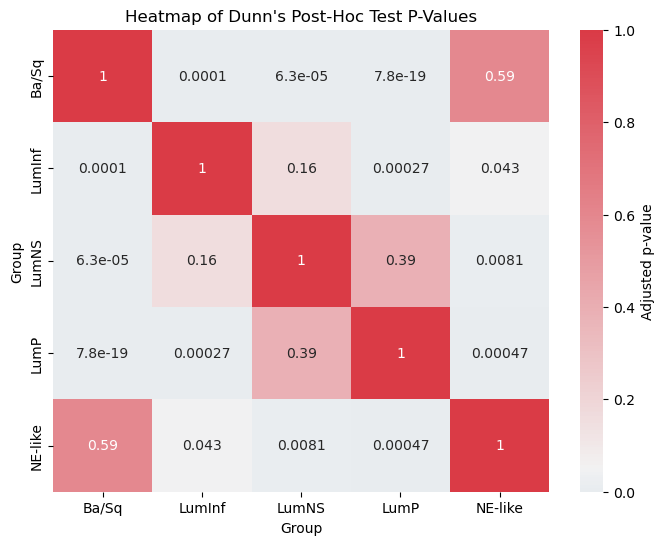

In [37]:
# classifier, gene = 'dendrogram_label', 'FOSL1'
classifier, gene = "TCGA408_classifier", "FGFR3"
sel_tpms = tum_tpms_v4.loc[["FGFR3"] + list(sel_tfs.index)].T
# sel_tpms = tum_tpms_v4.loc[sel_tfs.index].T
sel_tpms = np.log2(sel_tpms + 1)

dmy_df = pd.concat([morp_df[[classifier]], sel_tpms], axis=1).dropna()

group_sig_test(gene=gene, classifier=classifier, df=dmy_df)

# Selected genes and network metrics

In [38]:
import pickle as pickle
import os

ctrls_folder = f"{base_path}/{exp_folder_h42_ctrl}"
folders = next(os.walk(ctrls_folder), (None, None, []))[1]
ctrl_exps = {}
for folder in folders:
    stats_folder = f"{ctrls_folder}/{folder}/Stats/"
    files = next(os.walk(stats_folder), (None, None, []))[2]

    ctrl_idx = int(folder.split("hCtrl")[-1])
    ctrl_exps[ctrl_idx] = {}
    for file in files:
        if ("pickle" in file) or (file == "stats_master.tsv") or (file == ".DS_Store"):
            continue
        dmy_df = pd.read_csv(f"{stats_folder}/{file}", index_col="gene", sep="\t")

        dmy_df["num_tf"] = int(file.split("_")[-1].split("TF")[0])
        dmy_df["exp"] = file.replace("standard_int", "std")
        dmy_df["ctrl"] = ctrl_idx
        key_name = file.split(".tsv")[0].replace(".pickle", "").replace(f"standard_int_{folder}", "std")
        ctrl_exps[ctrl_idx][key_name] = dmy_df

In [39]:
genes = [
    "RARG",
    "PPARG",
    "ELF3",
    "AHR",
    "BNC1",
]
genes = list(tcga_markers) + ["BNC1", "AHR", "ELF3"]
comb_df = pd.DataFrame()
for ctrlExp in ctrl_exps.values():
    for net_stats in ctrlExp.values():
        dmy_df = net_stats.loc[net_stats.index.isin(genes)]
        comb_df = pd.concat([comb_df, dmy_df], axis=0)

# Mark the selected
comb_df["selected_tf"] = "No"
comb_df.loc[comb_df.index.isin(sel_tfs.index), "selected_tf"] = "Yes"

In [40]:
fig1 = px.box(comb_df.reset_index(), x="gene", y="ModCon_Rank", color="selected_tf", points="all")
fig2 = px.box(comb_df.reset_index(), x="gene", y="degree_t", color="selected_tf", points="all")
fig3 = px.box(comb_df.reset_index(), x="gene", y="degree_w", color="selected_tf", points="all")
title1, title2, title3 = "ModConRank", "Degree total", "Degree weight"
figs = [fig1, fig2, fig3]
titles = [title1, title2, title3]
num_cols = 1
subplots_config = {
    "num_cols": num_cols,
    "shared_x": False,
    "shared_y": False,
    "h_spacing": None,
    "v_spacing": 0.1,
    "main_title": "Genes and network metrics",
    "height": 900,
    "width": None,
    "y_title": None,
    "x_title": None,
    "specs": None,
}
fig = gh.helper_multiplots(figs, titles, subplots_config)
fig.show()

# Survival analysis

In [41]:
from lifelines.statistics import multivariate_logrank_test


def prep_survival(df, cs_model="RawKMeans", label="SBM"):

    colors_net, color_map = px.colors.qualitative.G10 + px.colors.qualitative.D3, {}
    for idx, val in enumerate(df[cs_model].unique()):
        color_map[val] = colors_net[idx]

    df[cs_model] = df[cs_model].astype(str)
    fig = survival_plot(df.drop(columns=["days_to_last_follow_up", "days_to_death"]), vu_output, classifier=cs_model, color_map=color_map)
    fig = fig.update_layout(title="{}. Survival analysis for {}".format(label, cs_model))

    return fig, color_map


def survival_sig(df, model):
    df = df.reset_index().rename(columns={"index": "Sample"}).copy(deep=True)
    classifier = model

    dmy = df[["days_to_last_follow_up", "days_to_death", classifier]].replace("--", 0).astype(int)
    dmy["last_contact"] = dmy[["days_to_last_follow_up", "days_to_death"]].max(axis=1).div(30)

    labels = list(df[model].unique())
    dmy = dmy[dmy[classifier].isin(labels)]
    print(labels)

    results = multivariate_logrank_test(dmy["last_contact"], dmy[classifier], dmy["days_to_death"])
    display(results.print_summary())
    print("{0:.6f}".format(results.p_value))


# add the survival metadata
tcga_metadata = pd.read_csv(f"{data_base}/tumour/TCGA_metadata.tsv", sep="\t", index_col="Sample")
morp_df["days_to_last_follow_up"] = tcga_metadata["days_to_last_follow_up"]
morp_df["days_to_death"] = tcga_metadata["days_to_death"]

In [46]:
morp_df[["consensus", "TCGA408_classifier", "dendrogram_cut", "KMeans_labels_6"]].to_csv(figures_path + "vu_net_1.tsv", sep="\t", index=True)

In [11]:
cluster_model = 'dendrogram_cut'
fig, dendo_color_map = prep_survival(morp_df, cs_model=cluster_model, label="CS_15")
# save_fig(name="Survival_plot_reward", fig=fig, base_path=figures_path, width=1400, height=600)

fig.update_layout(
    legend=dict(
        orientation="h",
        title="Network subtype",
        yanchor="bottom",
        y=0.9,
        xanchor="center",
        x=0.5,
        bgcolor="rgba(0,0,0,0)",
        font=dict(size=16, color="#003366"),
    ),
    title="",
    template="ggplot2",  # "ggplot2", "plotly_white"
    paper_bgcolor="rgba(0,0,0,0)",
    # plot_bgcolor="rgba(0,0,0,0)",
    xaxis=dict(tickfont=dict(size=16)),
    yaxis=dict(tickfont=dict(size=16)),
    font=dict(size=16),
    height=700
)
fig.add_annotation(text='Significance p<0.005', x=29, y=0.92, showarrow=False, font=dict(size=18, color="#003366"))
fig.show()
save_fig(name="survival_sel_tfs_cs", fig=fig, base_path=figures_path, width=1000, height=600)


In [45]:
morp_df[cluster_model] = morp_df[cluster_model].astype(float).astype(int)
survival_sig(morp_df, model=cluster_model)

[3, 4, 5, 12, 13]


<lifelines.StatisticalResult: multivariate_logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 4
         test_name = multivariate_logrank_test

---
 test_statistic      p  -log2(p)
          22.78 <0.005     12.80

None

0.000140


### Comparing survival

In [21]:
cluster_model = "dendrogram_cut"
comp_model = 'TCGA408_classifier'

if 0:
    colors_ref = px.colors.qualitative.Pastel2
    color_map = {
        "LumP": colors_ref[0],
        "Lum Inf/Ns": colors_ref[1],
        "High IFNG": colors_ref[2],
        "Low IFNG": colors_ref[3],
        "Med IFNG": colors_ref[4],
        "Ne": colors_ref[5],
    }

    color_map_grey = {label: "grey" for label in morp_df[comp_model].unique()}
    color_map = dict(color_map, **color_map_grey)

    # choose the subtypes for each to compare if needed
    select_labels_1, select_labels_2 = None, None

    colors_net = px.colors.qualitative.G10
    morp_df[cluster_model] = morp_df[cluster_model].astype(str)
    for idx, val in enumerate(morp_df[cluster_model].unique()):
        color_map[val] = colors_net[idx]

    fig = survival_comp(
        morp_df.drop(columns=["days_to_last_follow_up", "days_to_death"]),
        vu_output,
        classifier_1=cluster_model,
        classifier_2=comp_model,
        selected_labels_1=select_labels_1,
        selected_labels_2=select_labels_2,
        color_map=color_map,
    )
    fig = fig.update_layout(title="Survival analysis {}".format("VU + in-situ"))
    fig.update_layout(height=900)
    # save_fig(name="Survival_plot_reward", fig=fig, base_path=figures_path, width=1400, height=600)

### ESTIMATE score, immune infiltration

In [63]:
morp_df['Immune_score']=morp_df['Immune_score'].astype(float)
morp_df['ESTIMATE_score']=morp_df['ESTIMATE_score'].astype(float)
morp_df['Stromal_score']=morp_df['Stromal_score'].astype(float)
morp_df['IFNG_score'] = vu_output['IFNG_score'].astype(float)
morp_df['infiltration_score'] = vu_output['infiltration_score'].astype(float)

# dmy_df = morp_df[morp_df['KM']]
if 0:
    fig = px.scatter(morp_df, x="ESTIMATE_score", y='Stromal_score', color='dendrogram_label', size="infiltration_score")
    display(fig)

    fig = px.scatter(morp_df, x="ESTIMATE_score", y='Stromal_score', color='KMeans_labels_6', size="infiltration_score")
    display(fig)

### Other metadata exploration

In [27]:
tcga_meta_mmc1 = pd.read_excel(f"{data_base}/tumour/mmc1.xlsx", sheet_name='Master table').rename(columns={'Case ID': "Sample"}).set_index("Sample")
mmc1_cols = ['ethnicity', 'Noninvasive bladder history', 'Noninvasive bladder cancer therapy', 'Tobacco smoking history', 'Histologic subtype', "AJCC Tumor category", 'Anatomic location',
    "Lymphovascular invasion",
    "AJCC LN category",
    "Number of LNs examined",
    "AJCC metastasis category",
    "AJCC pathologic tumor stage",
    "Presence of prostate cancer",
    "AJCC prostate cancer stage",
    "Histologic grade",
    "Tissue source site",
    "Combined T and LN category",
    "Extracapsular extension",
    "Anatomic location",
    "Tumor Status",
    "Vital status",
    "Days to last followup",
    "Days until death",
    "Combined days to last followup or death",
    "Pathology classification",
    "Pathology abbreviated",
    "Inflammatory Infiltrate Response",
    "Squamous pathology",
    "Neuroendocrine pathology",
    "NMF based fraction APOBEC b mutations", "NMF based fraction APOBEC a mutations", "APOBEC induced mutation load  PMACD ", "APOBEC mutation load tertile"]
dmy_meta = pd.concat([tcga_meta_mmc1[tcga_meta_mmc1.index.isin(tcga_metadata.index)][mmc1_cols], tcga_metadata], axis=1)

# export to morpheus to visualised the metadata
if 0:
    sel_mut_cols = []
    for col in  tcga_meta_mmc1.columns:
        if "APOBEC" in col:
            sel_mut_cols.append(col)

    dmy_df = pd.concat([morp_df[['dendrogram_label', 'KMeans_labels_6', 'consensus', 'TCGA408_classifier', 'Immune_score', 'Stromal_score', 'ESTIMATE_score']], tcga_meta_mmc1[tcga_meta_mmc1.index.isin(morp_df.index)][sel_mut_cols]], axis=1 )
    dmy_df[[dmy_df.columns[-1]] + list(dmy_df.columns[:-1])].T.to_csv(figures_path+"apobec_meta_sel_tfs.tsv", sep='\t')

/Users/vlad/opt/anaconda3/envs/iNet_gt2/lib/python3.11/site-packages/openpyxl/worksheet/_read_only.py:81: UserWarning:

Unknown extension is not supported and will be removed



In [101]:
# tcga_metadata.loc[morp_df[morp_df['dendrogram_cut'] == 5].index].to_csv(figures_path + 'smallBasal_tcgaMetdata.tsv', sep="\t")
dmy_df = pd.concat([morp_df, dmy_meta[dmy_meta.index.isin(morp_df.index)]], axis=1 )
dmy_df['age_years'] = round(dmy_df['age_at_diagnosis_in_days'].astype(int) / 365, 2)
dmy_df['cigarettes_per_day'] = dmy_df['cigarettes_per_day'].replace("--", 0).astype(float)
kept_col = ['APOBEC mutation load tertile', 'Inflammatory Infiltrate Response', "Tobacco smoking history",
             'Presence of prostate cancer', 'Histologic grade', "AJCC metastasis category", 'Squamous pathology', 'Noninvasive bladder history', 'gender' ]

# make it nicer
dmy_df['gender'] = dmy_df['gender'].replace({'M': 'Male', 'F': 'Female'})
dmy_df['APOBEC mutation load tertile'] = dmy_df['APOBEC mutation load tertile'].replace({'High': 'High APOBEC', 'Low': 'Low APOBEC', 'No': 'No APOBEC'})
dmy_df['Presence of prostate cancer'] = dmy_df['Presence of prostate cancer'].replace({'NO': 'No Prostate cancer', 'YES': "Prostate Cancer", 'ND': 'Not Determined', '[Not Available]': 'Not Determined'})
dmy_df['Squamous pathology'] = dmy_df['Squamous pathology'].replace({'no': 'No Squamous', 'yes': "Squamous"})
dmy_df['Noninvasive bladder history'] = dmy_df['Noninvasive bladder history'].replace({'no': 'No NMIBC history', 'yes': "NMIBC history"})


figs, titles = [], []
for col in kept_col:
    fig = px.histogram(dmy_df, x='dendrogram_label', color=col, text_auto=True)
    titles.append(col)
    figs.append(fig)

In [108]:
%autoreload 2
subplots_config = {
    "num_cols": num_cols,
    "shared_x": False,
    "shared_y": False,
    "h_spacing": 0.04,
    "v_spacing": 0.1,
    "main_title": "Metadata exploration",
    "height": 1000,
    "width": None,
    "y_title": None,
    "x_title": None,
    "specs": None,
}

# Usage of the helper function with predefined figs and titles
fig = gh.helper_multiplots_hist(figs, titles, config=subplots_config, color_cols=kept_col, df=dmy_df)
fig.update_layout(
                #   paper_bgcolor="rgba(0,0,0,0)",
                  xaxis=dict(tickfont=dict(size=16)),
                  yaxis=dict(tickfont=dict(size=16)),
                  font=dict(size=14),
                  title = ''
                  )
save_fig(name="sel_tfs_tcga_meta", fig=fig, base_path=figures_path, width=1900, height=1100)
del fig

## Apply clustering analysis

In [47]:
plot_data = tum_tpms_v4.loc[sel_tfs.index]
plot_data = np.log2(plot_data + 1)

gh.find_pcs((plot_data))

Sum of 90% variance at PC: 15
Change < 1% at PC: 5


In [48]:
selected_clusters = ["Birch", "RawKMeans", "GaussianMixture", "Ward", "SpectralClustering", "Avg"]

# run experiments
outputs, _, all_metrics, _ = cs.compare_exp(
    plot_data, rob_comp=None, n_clusters=None, selected_clusters=selected_clusters, show_figures=False, show_consensus=True, pca_data=False, n_comp=15,
)
outputs.set_index("Sample", inplace=True)

show_figs=False
if show_figs:
    # Plot the metrics
    fig = cs.display_metrics(all_metrics, f"Cluster metrics for Selected TF", show_individual=False, verbose=True)
    gh.plot_individual_metric(all_metrics, pca=False, offset_db=4)

Variation per principal component [0.63955238 0.09883797] and the sum 73.84%


# Differentially Expressed Analysis

In [47]:
#### core-tf are genes that are in the 5% max, min of the the X-axis (AbsCa vs P0) and Y-axis (AbsCa vs UD) comparison
core_bladder = [
    "TGIF1",
    "PLSCR1",
    "AHR",
    "SAFB2",
    "CIC",
    "MBD6",
    "POGK",
    "ZNF524",
    "SPEN",
    "IRF7",
    "ELF4",
    "ZNF513",
    "FBXL19",
    "SP110",
    "TCF20",
    "KMT2A",
    "ZNF846",
    "ZNF335",
    "ZNF276",
    "ZNF211",
    "HIVEP2",
    "DOT1L",
    "MAFG",
    "ELK4",
    "HIVEP1",
    "ZNF609",
    "LCOR",
    "TRERF1",
    "NFAT5",
    "ZBTB21",
]
markers_var = {
    "98 TFs": list(sel_tfs.index),
    "tum only": only_tum,
    "non-tum only": only_h,
    "both": cmn_varied,
    "core bladder": core_bladder,
    "upReg_scc": found_upReg_scc,
    "downReg_scc": found_downReg_scc,
    "mes_like": [
        "VIM",
        "ZEB2",
        "FOX1",
        "GATA3",
        "KRT5",
        "KRT14",
    ],  # only the first 2 are high expressed in mes-like, the others are low expressed compared to NE and Basal
    "lum": ["MSX2", "MECOM", "HOXB6", "GRHL3", "BHLHE41", "ZBTB7C", "ZSCAN16", "ZNF224"],
}

# the axis specific are determined to be in 5% within the Axis
### Determined from dividing the quadrant in boxes and removing the core genes (within 5% of the axis) as well as the one close to the x axis
markers_diff = {
    "98 TFs": list(sel_tfs.index),
    "p0": ["KLF4", "ETS2", "PHF1", "ARID5B", "EGR1", "FOXQ1", "MAFF", "JUNB", "MAFK", "NFIL3", "SRF", "RUNX1", "CASZ1", "ZBTB10", "EBF4"],
    "ud": ["SLC2A4RG", "ZXDB", "SKI", "TP63", "ETS1"],
    "absCa": [
        "BCL6",
        "MSX2",
        "ELF3",
        "GRHL3",
        "REL",
        "KLF5",
        "ZNF552",
        "SATB1",
        "DBP",
        "ETV7",
        "ETV3",
        "MECOM",
        "REPIN1",
        "SP1",
        "ZNF586",
        "ZBTB4",
        "TEAD1",
        "ATMIN",
        "TMF1",
        "SP100",
        "FOXJ3",
        "MBD1",
        "STAT1",
        "ANKZF1",
        "IRF9",
        "STAT2",
    ],
    "absCa_absCa": ["NFATC4", "ZNF224", "ZSCAN16", "JRK", "BHLHE41", "HOXB6"],
    "absCa_ud": ["BNC1", "MSANTD3", "HES2"],
    "ud_p0": ["KLF6", "JUN", "FOSL1", "ERF", "IRF6", "KLF16"],
    "p0_absCa": [
        "NR4A2",
        "ATF3",
        "OVOL1",
        "ZBTB7C",
        "FOSL2",
        "BCL6",
        "MSX2",
        "MYCL",
        "ZNF750",
        "ELF3",
        "GRHL3",
        "REL",
        "KLF5",
        "ZNF552",
        "SATB1",
        "DBP",
        "ETV7",
        "ETV3",
        "MECOM",
        "REPIN1",
        "SP1",
        "ZNF586",
    ],
    "core bladder": core_bladder,
}

## Non tumour data

In [29]:
f_absCa_p0 = "sleuth_ABS-Ca_P0_v4_vulcano_labels.tsv"
f_ud_p0 = "sleuth_UD_P0_v4_vulcano_labels.tsv"
f_absCa_ud = "sleuth_ABS-Ca_UD_v4_vulcano_labels.tsv"

In [30]:
subtype = "cmn_varied"
volcano = dea.volcano(f_absCa_ud, base_path=dea_path, known_markers=False, markers=markers_var)
# scatter = sp.draw_scatter(absCa_p0, base_path=dea_path, selected_genes=[], known_markers=True)

volcano = dea_hp.toggle_legend(volcano, kept_traces=markers_var.keys())

volcano.add_annotation(text="UD", x=-4, y=25, showarrow=False, font=dict(size=18, color="#003366"))
volcano.add_annotation(text="AbsCa", x=7, y=25, showarrow=False, font=dict(size=18, color="#003366"))

volcano = volcano.update_layout(height=800)
# volcano.show()

Finished loading the data in 0.09929299354553223


### Pi plots

In [1]:
if 0:
    # used_markers = markers_diff
    used_markers = markers_var
    text_color = "#003366"
    display_quadrant, th = False, 0.05

    # It needs to be ther order of the quadrants
    axis_order = ['AbsCa', 'AbsCa', 'UD', 'P0']
    
    pi, pi_df = dea.plotPi(f_absCa_p0, f_absCa_ud, base_path=dea_path, known_markers=False, markers=used_markers)
    pi, core_bladder = dea.add_box_core(pi, pi_df, subset=sel_tfs, th=0.05, display=True)
    pi = dea_hp.toggle_legend(pi, kept_traces=used_markers.keys())
    pi.update_layout(
        legend=dict(
            orientation="h",
            # title = '',
            yanchor="bottom",
            xanchor="center",
            y=0.92,
            x=0.3,
            bgcolor="rgba(0,0,0,0)",
            font=dict(size=12, color="#003366"),
        ),
        template="ggplot2",
        # paper_bgcolor="rgba(0,0,0,0)",
        xaxis = dict(
            tickmode = 'linear',
            tick0 = 0,
            dtick = 25,
            tickfont=dict(size=16)
        ),
        yaxis = dict(
            tickmode = 'linear',
            tick0 = 0,
            dtick = 25,
            tickfont=dict(size=16)
        ),
        xaxis_title='Pi_P0_AbsCa',
        yaxis_title='Pi_AbsCa_UD',
        height=900
    )

    ##### Add annotations
    # Y axis
    pi.add_annotation(text='ABS-Ca', x=0, y=150, showarrow=False, font=dict(size=18, color=text_color))
    pi.add_annotation(text='UD', x=0, y=-70, showarrow=False, font=dict(size=18, color=text_color))
    # X-axis
    pi.add_annotation(text='P0', x=-220, y=0, showarrow=False, font=dict(size=18, color=text_color))
    pi.add_annotation(text='ABS-Ca', x=65, y=0, showarrow=False, font=dict(size=18, color=text_color))

    ##### Processing the quadrant
    sel_df = pi_df[pi_df.index.isin(sel_tfs.index)]

    axis_specific, quadrant_df = pd.DataFrame(), pd.DataFrame()
    ### Define the coordinates 
    # -- max/mins
    min_x, max_x = pi_df['x'].min(), pi_df['x'].max()
    min_y, max_y = pi_df['y'].min(), pi_df['y'].max()
    # -- Pi centre
    x_neg, x_pos = min_x*th, max_x*th
    y_neg, y_pos = min_y*th, max_y*th

    ### Define the rectangles
    # -- Axis rectangles 
    rectangles = [
        dict(type='rect', x1=x_pos, y1=max_y, x0=x_neg, y0=0, line=dict(color='black', width=1), layer='below', fillcolor='yellow'),
        dict(type='rect', x1=max_x, y1=y_pos, x0=0, y0=y_neg, line=dict(color='black', width=1),  layer='below'),
        dict(type='rect', x0=x_neg, y0=min_y, x1=x_pos, y1=0, line=dict(color='black', width=1),  layer='below', fillcolor='blue'),
        dict(type='rect', x0=min_x, y0=y_neg, x1=0, y1=y_pos, line=dict(color='black', width=1), layer='below', fillcolor='orange'),
    ]
    # -- Quadrant 
    quadrant = [
        dict(type='rect', x0=x_pos, y0=y_pos, x1=max_x, y1=max_y, line=dict(color='black', width=1), layer='below', fillcolor='blue'),
        dict(type='rect', x1=max_x, y1=y_neg, x0=x_pos, y0=min_y, line=dict(color='black', width=1),  layer='below', fillcolor='purple'),
        dict(type='rect', x1=x_neg, y1=y_neg, x0=min_x, y0=min_y, line=dict(color='black', width=1),  layer='below', fillcolor='red'),
        dict(type='rect', x0=min_x, y0=y_pos, x1=x_pos, y1=max_y, line=dict(color='black', width=1), layer='below', fillcolor='magenta'),
    ]

    ########## Find the points in the quadrant ##########
    for idx, rect in enumerate(rectangles):
        pi.add_shape(**rect)

        inside_df = dea_hp.filter_points_in_rectangle(sel_df, rect)
        inside_df['label'] = axis_order[idx]

        axis_specific = pd.concat([axis_specific, inside_df], axis=0)

    ########## Find the points in the quadrant ##########
    for idx, rect in enumerate(quadrant):
        if display_quadrant:
            pi.add_shape(**rect)

        inside_df = dea_hp.filter_points_in_rectangle(sel_df, rect)
        subtype = f'{axis_order[idx]}-{axis_order[(idx+1) % (len(axis_order))]}'
        inside_df['label'] = subtype
        quadrant_df = pd.concat([quadrant_df, inside_df], axis=0)
    pi.show()

In [53]:
sel_tfs['varied_label'] = ''
for key, val in markers_var.items():
    if key == '98 TFs':
        continue
    
    if key == 'core bladder':
        sel_tfs.loc[(sel_tfs.index.isin(val)) & (sel_tfs['varied_label'] == ""), 'varied_label'] = key
    else:
        sel_tfs.loc[sel_tfs.index.isin(val), 'varied_label'] = key


sel_tfs['diff_associated'] = ''
for key, val in markers_diff.items():
    sel_tfs.loc[sel_tfs.index.isin(val), 'diff_associated'] = key

# sel_tfs.to_csv(f"{figures_path}/selected_tfs.tsv", sep='\t')

In [77]:
p0 = ["PHF1", "JUNB", "SRF, CASZ1", "FOSL2", "NFIL3", "RUNX1", "SRF"]
p0_ud = ["ERF", "IRF6", "KLF16", "SLC2A4RG"]
ud = ["ZXDB", "ETS1", "SKI"]
ud_abs = ["MSANTD3"]

abs_ca = [
    "BCL6",
    "FOXJ3",
    "TMF1",
    "ELF3",
    "STAT2",
    "MECOM",
    "ETV7",
    "ETV3",
    "SP100",
    "NFATC4",
    "ZNF586",
    "SATB1",
    "ZBTB4",
    "REPIN1",
    "STAT1",
    "ATMIN",
    "CASZ1",
    "IRF9",
    "TEAD1",
    "ZSCAN16",
    "MBD1",
    "SP1",
    "ANKZF1",
    "ZNF224",
    "KLF5",
    "DBP",
]
# abs_ca = pd.Index(set(sel_tfs[sel_tfs['varied_label'] == ''].index) - set(p0_ud + p0 + ud + ud_abs))

## Tumour data

In [22]:
f_mes_small_basal = "Mes-like_vs_Small_BaSq_v1_vulcano_labels.tsv"
f_mes_large = "Mes-like_vs_Large_BaSq_v1_vulcano_labels.tsv"

f_mes_lumInf = "Mes-like_vs_LumInf_v1_vulcano_labels.tsv"
f_mes_large_lump = "Mes-like_vs_LumP_v1_vulcano_labels.tsv"

f_small_large_basla = "Large_BaSq_vs_Small_BaSq_v1_vulcano_labels.tsv"

f_large_basal_large_lump = "Large_BaSq_vs_LumP_v1_vulcano_labels.tsv"
f_small_basal_large_lump = "Small_BaSq_vs_LumP_v1_\vulcano_labels.tsv"

f_large_basal_lum_inf = "Large_BaSq_vs_LumInf_v1_vulcano_labels.tsv"
f_small_basal_lum_inf = "Small_BaSq_vs_LumInf_v1_vulcano_labels.tsv"

In [49]:
used_markers = markers_var
height = 900

pi, pi_df = dea.plotPi(f_large_basal_lum_inf, f_small_basal_lum_inf, base_path=dea_path_tum, known_markers=False, markers={}, height=height)

# pi, core_bladder = dea.add_box_core(pi, pi_df, subset=sel_tfs, th=0.05, display=True)
# pi = toggle_legend(pi, kept_traces=used_markers.keys())

### Define the coordinates
# -- max/mins
min_x, max_x = pi_df["x"].min(), pi_df["x"].max()
min_y, max_y = pi_df["y"].min(), pi_df["y"].max()

display_quadrant, th = False, 0.05
if display_quadrant:
    sel_df = pi_df[pi_df.index.isin(sel_tfs.index)]
    axis_order = ["mes-like", "large-basal", "small_basal", "small_basal"]
    axis_specific, quadrant_df = pd.DataFrame(), pd.DataFrame()

    # -- Pi centre
    x_neg, x_pos = min_x * th, max_x * th
    y_neg, y_pos = min_y * th, max_y * th

    quadrant = [
        # dict(type='rect', x0=x_pos, y0=y_pos, x1=max_x, y1=max_y, line=dict(color='black', width=1), layer='below', fillcolor='yellow'),
        # dict(type='rect', x1=max_x, y1=y_neg, x0=x_pos, y0=min_y, line=dict(color='black', width=1),  layer='below'),
        dict(type="rect", x1=x_neg, y1=y_neg, x0=min_x, y0=min_y, line=dict(color="black", width=1), layer="below", fillcolor="blue"),
        dict(type="rect", x0=min_x, y0=y_neg, x1=0, y1=y_pos, line=dict(color="black", width=1), layer="below", fillcolor="orange"),
        dict(type="rect", x0=x_neg, y0=min_y, x1=x_pos + max_x * 0.45, y1=0, line=dict(color="black", width=1), layer="below", fillcolor="yellow"),
    ]

    ########## Find the points in the quadrant ##########
    for idx, rect in enumerate(quadrant):
        if display_quadrant:
            pi.add_shape(**rect)

        inside_df = dea_hp.filter_points_in_rectangle(sel_df, rect)
        subtype = f"{axis_order[idx]}-{axis_order[(idx+1) % (len(axis_order))]}"
        inside_df["label"] = subtype
        quadrant_df = pd.concat([quadrant_df, inside_df], axis=0)
# pi.show()

In [ ]:
height = 900
file_1, file_2 = f_small_large_basla, f_mes_small_basal
pi, pi_df = dea.plotPi(file_1, file_2, base_path=dea_path_tum, known_markers=False, markers={}, height=height)
# -- max/mins
min_x, max_x = pi_df["x"].min(), pi_df["x"].max()
min_y, max_y = pi_df["y"].min(), pi_df["y"].max()

# Marking the corner ref
ref_point = min_x, min_y
pi_df["dist"] = dea_hp.distance_from_ref(pi_df, ref_point)
rank = pi_df["dist"].rank(ascending=False, method="first").sort_values(ascending=True)

# Re-draw with the rankings
used_markers = {"top_500": rank[rank < 500].index, "98 TFs": sel_tfs.index}
pi, pi_df = dea.plotPi(file_1, file_2, base_path=dea_path_tum, known_markers=False, markers=used_markers, height=height)
pi_df["rank"] = rank
pi.show()

In [54]:
# Used for visualisation of the markers
if 0:
    min_size, max_size = 2, 20

    # Normalize sizes
    min_orig, max_orig = pi_df['rank_dist'].min() , pi_df['rank_dist'].max()
    normalized_sizes = min_size + ( pi_df['rank_dist'] - min_orig) * (max_size - min_size) / (max_orig - min_orig)

    pi.update_traces(marker=dict(size=normalized_sizes))
    # px.histogram(pi_df, x='rank_dist', nbins=1000)


### GSEA

In [50]:
import gseapy as gp

msigdb_hallmarks = "../../data/GSEA/msigDB/h.all.v2023.2.Hs.symbols.gmt"
msigdb_reactome = "../../data/GSEA/msigDB/c2.cp.reactome.v2023.2.Hs.symbols.gmt"
msigdb_tf = "../../data/GSEA/msigDB/c3.tft.v2023.2.Hs.symbols.gmt"
msigdb_cancer = "../../data/GSEA/msigDB/c4.all.v2023.2.Hs.symbols.gmt"
msigdb_onco_sig = "../../data/GSEA/msigDB/c6.all.v2023.2.Hs.symbols.gmt"
msigdb_all = "../../data/GSEA/msigDB/msigdb.v2023.2.Hs.symbols.gmt"

databases = {
    "hallmark": {"path": msigdb_hallmarks},
    "onco_sig": {"path": msigdb_onco_sig},
    "reactome": {"path": msigdb_reactome},
    ### Un-comment to run the following pathways
    # "tf": { "path": msigdb_tf },
    # "can_path": { "path": msigdb_cancer }, #canonical pathway
    # "all": { "db": msigdb_all },
}

In [54]:
df = pi_df.reset_index()[["genes", "rank"]]
version = "smallBasal_tst/"
for key, value in databases.items():
    print(key)

    path = f"{figures_path}/GSEA/{version}/{key}"
    rank_gsea = gp.prerank(
        rnk=df, gene_sets=value["path"], permutation_num=1000, outdir=path, no_plot=False, ascending=False, format="png", seed=20, graph_num=20, threads=12
    )  # Change graph_num if you want to produce enrichment plots

    value["res"] = rank_gsea

    # Plot summaries plot
    fig = gsea_hp.plot_enrichr_summary(rank_gsea.res2d, label=key, savePath=path)
    fig2, top_terms = gsea_hp.plot_top_gsea(res=rank_gsea, path=path, num=10, label=key)

    dmy_df = gsea_hp.process_gsea({key: rank_gsea}, database=key, th=5000)
    dmy_df = dmy_df[["Term", "NES", "#matched_lead_genes", "matched_lead_ratio", "FDR q-val"]].sort_values(by="matched_lead_ratio", ascending=False)
    match_terms = dmy_df[(dmy_df["FDR q-val"] <= 0.05) & (dmy_df["matched_lead_ratio"] != 0.0)].Term[0:10]

    fig2, _ = gsea_hp.plot_top_gsea(res=rank_gsea, path=path, num=10, label=key, man_terms=match_terms)

hallmark
onco_sig
reactome


### Global GSEA analysis

In [55]:
runs_config = {
    "smallBasal": {"file_1": f_mes_small_basal, "file_2": f_small_large_basla, "ref_x": "min", "ref_y": "min"},
    "largeBasal": {"file_1": f_large_basal_lum_inf, "file_2": f_large_basal_large_lump, "ref_x": "max", "ref_y": "max"},
    "mesLike": {"file_1": f_mes_large_lump, "file_2": f_mes_lumInf, "ref_x": "max", "ref_y": "max"},
    "lumInf": {"file_1": f_large_basal_lum_inf, "file_2": f_small_basal_lum_inf, "ref_x": "min", "ref_y": "min"},
    "largeLuminal": {"file_1": f_large_basal_large_lump, "file_2": f_small_basal_large_lump, "ref_x": "min", "ref_y": "min"},
    "smallBasal_2": {"file_1": f_small_basal_lum_inf, "file_2": f_small_basal_large_lump, "ref_x": "max", "ref_y": "max"},
}

In [ ]:
version = "v2"

new_runs = {}
for subtype, config in runs_config.items():
    print(f"##### {subtype} #####")

    # Add the path
    config["path"] = f"{figures_path}/GSEA/{version}/{subtype}/"

    # Run the Pi value - the saved Pi plot is a check for selecting the right quadrant
    config["pi"], config["pi_df"] = gsea_hp.rank_pi_vals(subtype, config, dea_path=dea_path_tum, custom_points={"98 TFs": list(sel_tfs.index)})

    # Run the GSEA
    gsea_res = gsea_hp.run_gsea(subtype, config, databases=databases)

    # Merging two dict, requires python >3.5
    new_runs[subtype] = {**config, **gsea_res}

In [ ]:
common_paths = {}
for database in databases.keys():
    print(database)
    all_df = pd.DataFrame()
    for key, config in new_runs.items():
        if key == "smallBasal_2":
            continue
        # print(f"---> {key}")
        df = gsea_hp.process_gsea(config, database=database, th=5000)
        # Saved for all-df
        df["subtype"] = key
        df["database"] = database
        df["Term"] = df["Term"].str.replace(f"{database.upper()}_", "")
        all_df = pd.concat([all_df, df.drop(columns=["Name"])], axis=0)

    common_paths[database] = all_df

In [ ]:
# to test
if 1:
    term = "REACTOME_RESPONSE_OF_EIF2AK4_GCN2_TO_AMINO_ACID_DEFICIENCY"

    config = new_runs["largeLuminal"]
    res2d = config["reactome"].res2d
    test_term = res2d[res2d["Term"] == term]["Lead_genes_list"].values[0]
    used_markers = {"test_term": test_term}

    pi, pi_df = dea.plotPi(config["file_1"], config["file_2"], base_path=dea_path_tum, known_markers=False, markers=used_markers, height=height)
    pi = dea_hp.toggle_legend(pi, kept_traces=used_markers.keys())
    pi.show()

In [ ]:
# tst_df = new_runs["largeLuminal"]["reactome"].res2d.copy(deep=True)
# tst_df = tst_df[tst_df["FDR q-val"] <= 0.05]
# tst_df["subtype"] = "lumP"
# tst_df["database"] = "reactome"
# tst_df.sort_values(by="FDR q-val", ascending=False)[save_cols]

### Uniquely

In [ ]:
th = 10
save_cols = ["subtype", "Term", "NES", "FDR q-val", "#lead_genes", "#matched_lead_genes", "matched_lead_ratio", "database", "lead_genes_matched"]
comb_all = pd.DataFrame()
plot = True
for database, all_df in common_paths.items():
    if database != "reactome":
        continue

    print(f"### {database}")
    top_pathwayws = {}
    top_df = pd.DataFrame()
    for subtype in all_df["subtype"].unique():
        sel_df = all_df[all_df["subtype"] == subtype].sort_values(by=["NES"], ascending=False)
        sel_df = sel_df[sel_df["FDR q-val"] <= 0.05]
        unique_subtype = sel_df["Term"].values[:th]

        top_df = pd.concat([top_df, sel_df.iloc[:th]], axis=0)
        top_pathwayws[subtype] = set(unique_subtype)

    unique_term_subtype = {}
    cmn_all = pd.DataFrame()
    for key, ref_val in top_pathwayws.items():
        # plot for reference the top 10 by man selected
        if plot:
            config = new_runs[key]
            path = config["path"].replace(key, "")
            terms = [f"{database.upper()}_" + x for x in list(ref_val)]
            if database == "onco_sig":
                terms = list(ref_val)
            gsea_hp.plot_top_gsea(res=config[database], path=f"{path}/man_sel_{th}/{database}/", label=f"{key}", num=th, man_terms=terms, database=database)

        unique, cmn = ref_val, {}
        for key_2, comp_val in top_pathwayws.items():
            if key_2 == key:
                continue

            unique = unique - comp_val
            cmn = unique & comp_val

        unique_term_subtype[key] = unique
        if len(unique):
            print(f"---> {len(unique)} uniq in top {th} for {key}")
            df = top_df[top_df["Term"].isin(list(unique))]
            df.to_excel(f"{new_runs[key]['path']}/{database}/{th}_uniq_{database}_{key}.xlsx")
            cmn_all = pd.concat([cmn_all, df], axis=0)
        else:
            print(f"No unique path for {key}")

        if len(cmn):
            print(f"-> Cmn pathways {cmn}")

    cmn_all["FDR q-val"] = cmn_all["FDR q-val"].astype(float)
    cmn_all["NES"] = cmn_all["NES"].astype(float)
    cmn_all["Term"] = cmn_all["Term"].str.replace("_", " ")
    cmn_all = cmn_all.round(3)
    comb_all = pd.concat([comb_all, cmn_all], axis=0)
    cmn_all.to_excel(f"{figures_path}/GSEA/{version}/{database}_th_{th}.xlsx", columns=save_cols)

### reactome
---> 10 uniq in top 10 for smallBasal
---> 5 uniq in top 10 for largeBasal
No unique path for mesLike
---> 1 uniq in top 10 for lumInf
---> 10 uniq in top 10 for largeLuminal


In [ ]:
gsea_hp.plot_top_gsea(res=config[database], path=f"{path}/man_sel_{th}/{database}/", label=f"{key}", num=th, man_terms=terms)

(None,
 ['REACTOME_FORMATION_OF_WDR5_CONTAINING_HISTONE_MODIFYING_COMPLEXES',
  'REACTOME_NONSENSE_MEDIATED_DECAY_NMD',
  'REACTOME_BRANCHED_CHAIN_AMINO_ACID_CATABOLISM',
  'REACTOME_EUKARYOTIC_TRANSLATION_INITIATION',
  'REACTOME_EUKARYOTIC_TRANSLATION_ELONGATION',
  'REACTOME_PARACETAMOL_ADME',
  'REACTOME_SELENOAMINO_ACID_METABOLISM',
  'REACTOME_MITOCHONDRIAL_FATTY_ACID_BETA_OXIDATION',
  'REACTOME_RESPONSE_OF_EIF2AK4_GCN2_TO_AMINO_ACID_DEFICIENCY',
  'REACTOME_SRP_DEPENDENT_COTRANSLATIONAL_PROTEIN_TARGETING_TO_MEMBRANE'])

### Pi - shared genes

Showing that there are the same genes shared across the pi plots

In [40]:
prev_df = {}
for key, config in new_runs.items():
    print(f"{key} - {config['pi_df'].shape[0]}")
    if len(prev_df) == 0:
        prev_df = set(config["pi_df"].index)
    prev_df = set(config["pi_df"].index) & prev_df
print(len(prev_df))

smallBasal - 32376
largeBasal - 32376
mesLike - 32376
lumInf - 32376
largeLuminal - 32376
smallBasal_2 - 32376
32376


# Linking to the network

## Load experiment sets

In [21]:
%autoreload 2
exp_folder_h42 = "network_I/healthy42/"

all_h = ExperimentSet("allHealthy42", base_path, exp_folder_h42, tcga_mutations_df, sel_sets = ["5K"], rel_path="../")
all_h.export_to_gephi(save=False)

tf_range = [3, 6, 10]
exps, entropy = GtExp.load_sbm_exps(all_h, name="standard_5K", exp_type="h42_700_degreeCor", tf_range=tf_range)

##### Experiment labels:  dict_keys(['standard_5K_3TF', 'norm3_5K_3TF', 'beta_5K_3TF', 'standard_5K_6TF', 'standard_5K_10TF', 'norm3_5K_6TF', 'beta_5K_6TF', 'norm3_5K_10TF', 'beta_5K_10TF', 'standard_5K_4TF', 'standard_5K_7TF', 'standard_5K_8TF', 'standard_5K_5TF', 'standard_5K_9TF', 'norm3_5K_4TF', 'beta_5K_4TF', 'standard_5K_15TF', 'standard_5K_20TF', 'standard_5K_30TF', 'standard_5K_25TF', 'standard_5K_40TF', 'standard_5K_35TF', 'standard_5K_45TF', 'standard_5K_50TF', 'standard_5K_12TF', 'standard_5K_14TF', 'standard_5K_11TF', 'standard_5K_13TF'])
### Loaded standard_int_healthy42_5K_3TF
### Loaded standard_int_healthy42_5K_6TF
### Loaded standard_int_healthy42_5K_10TF


In [22]:
%%capture
folders = next(os.walk(base_path + exp_folder_h42_ctrl), (None, None, []))[1]
args, h_ctrls = [], {}
for folder in folders:
    hCtrl_path = "{}/{}/".format(exp_folder_h42_ctrl, folder)
    idx = int(folder.split("hCtrl")[-1])
    h_ctrls[idx] = ExperimentSet("allHealthy42", base_path, hCtrl_path, tcga_mutations_df, sel_sets=["5K"], rel_path="../")
    h_ctrls[idx].export_to_gephi(save=False)

In [22]:
%autoreload 2
import graph_tool.all as gt

sel_gt: GtExp = exps['6']
gt_g: gt.Graph = sel_gt.gt_g

com_df = sel_gt.get_gt_df()
sel_gt.graph_type = 'sbm'
sel_gt.nodes_df['node_idx'] = com_df['node_idx']
sel_gt.nodes_df['max_b'] = com_df['max_b']
sel_gt.nodes_df['ModCon_Rank'] = 0

sel_gt.add_vp(state_idx=0, mut_df=tcga_mutations_df)
sel_gt.add_gt_prop_draw(sel_gt.gt_g, com_df=com_df, tf_list=tf_list)

gt_state: gt.BlockState = sel_gt.states[0]['state']
pv = sel_gt.states[0]['pv']
gt_g = sel_gt.gt_g

vp_dg = gt_g.degree_property_map(deg="total", weight=gt_g.ep["weight"])


## In which communities relevant genes are

From previous work in this NB we have selected a few list of markers for basal, luminal and varied. I am interested to understand in which communities these are

In [33]:
nodes_df: pd.DataFrame = sel_gt.nodes_df.copy(deep=True)

In [ ]:
gene_list = genes_lum
sel_df = nodes_df.loc[nodes_df.index.isin(gene_list)]
sel_df["max_b"] = sel_df["max_b"].astype(str)
fig1 = px.bar(sel_df, x="max_b", color="max_b", title="Luminal genes and where in a standard network these are")

gene_list = genes_basal
sel_df = nodes_df.loc[nodes_df.index.isin(gene_list)]
sel_df["max_b"] = sel_df["max_b"].astype(str)
fig2 = px.bar(sel_df, x="max_b", color="max_b", title="Basal genes and where in a standard network these are")

save_fig(name="lum_com_markers", fig=fig1, base_path=figures_path, height=500, width=None)
save_fig(name="basal_com_markers", fig=fig2, base_path=figures_path, height=500, width=None)

In [29]:
sel_gt.graph = sel_gt.gt_g
graph_stats = sel_gt.compute_graph_stats()
size_stats = nodes_df["max_b"].value_counts().reset_index().rename(columns={"count": "com_size"})

for com in size_stats.index:
    genes_com = nodes_df.loc[nodes_df["max_b"] == com].index
    genes_com = graph_stats.loc[graph_stats.index.isin(genes_com)]["degree_t"]
    size_stats.loc[size_stats.index == com, "mean_degree_t"] = genes_com.mean()
    size_stats.loc[size_stats.index == com, "std_degree_t"] = genes_com.std()

size_stats["max_b"] = size_stats["max_b"].astype(str)
fig1 = px.bar(size_stats, x="max_b", y="com_size", title="Size")
fig2 = px.bar(size_stats, x="max_b", y="mean_degree_t", error_y="std_degree_t", title="Average degree t")

# display(fig1)
# display(fig2)

In [82]:
under_th = sel_gt.edges_df[sel_gt.edges_df['Weight'] < 0.5].shape[0]/sel_gt.edges_df.shape[0] * 100
fig = px.histogram(sel_gt.edges_df, x='Weight', title=f'Weight distributiuon; edges <0.5:{round(under_th, 3)}%')
fig.update_layout(
    title="",
    font=dict(size=16, color="#003366"),
    xaxis=dict(tickfont=dict(size=16)),
    yaxis=dict(tickfont=dict(size=16),),
    paper_bgcolor="rgba(0,0,0,0)",

)
save_fig(name="weight_distrib", fig=fig, base_path=figures_path, height=600, width=1400)

## Exploring gene neighbors

In [ ]:
def get_gene_neigbhors(gt_exp: GtExp, gene_name="BNC1"):

    neighbors = gt_exp.filter_graph(gene=gene_name)
    gt_exp.gt_g.set_vertex_filter(None)

    neighbors_stats, neighbors_df = gt_exp.process_neigbhors(neighbors)
    return neighbors_stats, neighbors_df

In [31]:
n_stats, n_df = get_gene_neigbhors(sel_gt, gene_name="BNC1")
gt_g.set_vertex_filter(None)
n_stats

BNC1. Idx = 505. Comm = 3


,com,com_ratio,mut_burden,num_TF,num_found,com_size
0,3.0,0.1105,13,0,21,190
1,4.0,0.0064,1,0,1,157
2,8.0,0.0057,0,0,1,176
3,9.0,0.0040,1,0,1,250


In [34]:
for gene in ["AHR"]:
    # print(gene)
    # if gene not in nodes_df.index:
    #     continue

    neigbhors = sel_gt.filter_graph(gene=gene, show_own_com=False)
    # sel_gt.gt_g.set_vertex_filter(None)
    # stats_neigbhors = sel_gt.process_neigbhors(v_idxs=neigbhors)

    draw_results = gt_state.draw(
        # pos=pos,
        # layout="sfdp",
        vertex_shape="pie",
        vertex_pie_fractions=pv,
        inline=False,
        # vertex_color = vp_colors_rank,
        vertex_text=gt_g.vp.prcsd_gene,
        display_props=gt_g.vp.display_prop,
        # subsample_edgesint=int(gt_g.num_edges() * 0.5),
        output_size=(1000, 1000),  # good to visualised in Notebook
        # ######## For mut_count ########
        # vertex_size=gt.prop_to_size((gt_g.vp["sel_com"]), 1, 10, power=0.5),
        # vertex_font_size=gt.prop_to_size(gt_g.vp.is_tf, 15, 30, power=0.5),
        # vertex_font_size=gt.prop_to_size(gt_g.vp.is_tf, 5, 10, power=0.5),
        edge_pen_width=gt.prop_to_size(gt_g.ep.weight, 2, 10, power=1),
        vertex_size=gt.prop_to_size(vp_dg, 35, 35, power=1),
        ######## is TF ########
        # vertex_size=gt.prop_to_size(gt_g.vp.is_tf, 10, 30, power=0.5),
        # vertex_font_size=gt.prop_to_size(gt_g.vp.mut_count, 5, 20, power=1),
        ##### edges properties
        # edge_pen_width=gt.prop_to_size(gt_g.ep.weight, 5, 10, power=0.01, log=True),
        # key_press_callback=callback_hsbm,
        output=f"{figures_path}/gt/luminal/net_{gene}.pdf",
        # hide=0,
        update_layout=False,
        nodesfirst=False,
        # beta=0.7,
        # chord_scale=5,
        # display_props_size=16,
    )

AHR. Idx = 266. Comm = 10


/Users/vlad/opt/anaconda3/envs/iNet_gt2/lib/python3.11/site-packages/graph_tool/draw/cairo_draw.py:681: UserWarning:

Unknown parameter: display_props

/Users/vlad/opt/anaconda3/envs/iNet_gt2/lib/python3.11/site-packages/graph_tool/draw/cairo_draw.py:681: UserWarning:

Unknown parameter: update_layout



In [41]:
pos = gt.sfdp_layout(gt_g, gamma=2, C=5)

draw_results = gt_state.draw(
    pos=pos,
    vertex_shape="pie",
    vertex_pie_fractions=pv,
    inline=False,
    vertex_text=gt_g.vp.prcsd_gene,
    display_props=gt_g.vp.display_prop,
    subsample_edgesint=int(gt_g.num_edges() * 0.5),
    output_size=(10000, 10000),  # good to visualised in Notebook
    # ######## For mut_count ########
    edge_pen_width=gt.prop_to_size(gt_g.ep.weight, 2, 10, power=1),
    vertex_size=gt.prop_to_size(vp_dg, 35, 35, power=1),
    ######## is TF ########
    output=f"/Users/vlad/Documents/Code/York/Phd_thesis_exp/results/network_I/Gephi/sbm_std_tum_5K_6TF.pdf",
    update_layout=True,
    nodesfirst=False,
)